# Evaluation of the IR System with the top ids already generated

- Lyrics Features used
    - tfidf
    - word2vec
    - **bert**

- Audio Features used
    - mfcc bow
    - mfcc stats
    - essentia
    - blf delta spectral
    - blf correlation
    - blf logfluc
    - **blf spectral**
    - blf spectral contrast
    - blf var delta spectral
    
-  Video Features used
    - incp
    - vgg19
    - **resnet**

In [1]:
import pandas as pd
import numpy as np
from os.path import exists
from tqdm import tqdm
import re
import datatable as dt
from matplotlib import pyplot as plt
import scipy.stats as stats
# Variables and functiones own defined
from files import *
from functions import *
from collections import defaultdict

In [2]:
def change_id_to_keys(df, id_to_keys):
    df.set_index(np.asarray([id_to_keys[i] for i in df.index.values]), inplace=True)
    df.index.astype(np.int32, copy=False)

In [3]:
# Datatype used to reduce memory required
DTYPE = np.float32

In [4]:
# Configuration for plots, not important

plt.rcParams['font.size'] = 18
# Set the axes title font size
plt.rc('axes', titlesize=16)
# Set the axes labels font size
plt.rc('axes', labelsize=16)
# Set the font size for x tick labels
plt.rc('xtick', labelsize=16)
# Set the font size for y tick labels
plt.rc('ytick', labelsize=16)

In [5]:
# Relation of original id, to new id, previously created
relation_ids = pd.read_csv("./data/relation_original_new_ids.csv").set_index('original').astype(np.int32)
id_to_key = dict(zip(relation_ids.index.values, relation_ids['newId'].values))

relation_ids.head(2)

,newId
original,
0009fFIM1eYThaPg,0
0010xmHR6UICBOYT,1


In [6]:
genres  = dt.fread(file_genres_2).to_pandas().set_index('id')
change_id_to_keys(genres,id_to_key)

## First Get the number of relevant songs for each query

First we need to get the number of relevant songs for each query for some of the similarity metrics.
Therefore we calculate it and save them in a dataset for faster results in the future

1. The first step is to adapt the genres dataframe

In [7]:
# First, we change the genre column to be a list
genres['genre']= genres.genre.apply(lambda x: get_genres(x))

# This is to get a list of the available genres and also its frequency
genre_frequencies = defaultdict(int)
all_genres = genres["genre"]
for song in all_genres:
    for genre in song:
        genre_frequencies[genre] += 1
        
# We create a new dataframe that will encode which genres have each song
# We initialize to 0, then we will fill it.
genre_song = pd.DataFrame(
    0,
    columns=genre_frequencies.keys(), 
    index=genres.index.values)

# For each song, we fill the genres that contain each song with 1
for index in tqdm(genre_song.index.values):
    genres_by_song={}
    for genre in genres.loc[index].values[0]:
        genres_by_song[genre] = 1
    genre_song.loc[[index], list(genres_by_song.keys())] = list(genres_by_song.values())

100%|███████████████████████████████████| 68641/68641 [00:57<00:00, 1195.32it/s]


In [8]:
# Ids within pop
genre_song["pop"][genre_song["pop"] > 0].index.values

array([    0,     7,    11, ..., 68635, 68638, 68639])

In [9]:
# Relation of which genres has which songs and viceversa
genre_song.loc[[0,7,11]]

,pop,beats,underground hip hop,lo fi,hard rock,classic rock,rock,progressive rock,album rock,space rock,...,fallen angel,gabba,prank,spanish electropop,czech folk,steelpan,abstract beats,neo mellow,neo singer songwriter,viral pop
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


2. Then for each song, we count how many songs, should be included for each query.
    For example for query1 with genres ['pop', 'rock'] we need to know how many different songs will match 'pop' and 'rock' since we are considering the whole dataset.

    This is done in the following code. We only need to run it once, and then store the relation of id-noRelevantResults. Took like 3 hours to do it. 
    *(Maybe could be improved)*

In [10]:
file_relevant_results_by_id = './data/relevant_results_by_newid.csv'

if( exists(file_relevant_results_by_id)):
    relevant_results_by_id = pd.read_csv(file_relevant_results_by_id).set_index('index').astype(np.int32)
else:
    number_relevant = np.zeros(len(genres.index.values), dtype=DTYPE)
    i=0
    for song in tqdm(genres.index.values):
        list_songs = np.array([], dtype=np.int32)
        # Get songs contained in each genre of the current query
        for genre in genres.loc[song].values[0]:
            idSongs = genre_song[genre_song[genre]>0].index.values
            list_songs = np.concatenate((list_songs, idSongs), axis=None)
        # Save the union of the ids without duplicates
        number_relevant[i] = (np.unique(list_songs).shape[0])
        i+=1
    relevant_results_by_id = pd.DataFrame(
        number_relevant,
        index=genres.index.values,
        columns=['relevants'],
        dtype=np.int32
    )
    dt.Frame(relevant_results_by_id.reset_index()).to_csv(file_relevant_results_by_id)

In [11]:
relevant_results_by_id.head(2)

,relevants
index,
0,28841
1,2787


In [12]:
dt.Frame(relevant_results_by_id.reset_index()).to_csv("data/test.csv")

In [13]:
spotify_data  = dt.fread("./../task3Data/id_metadata_mmsr.tsv", header=True).to_pandas().set_index('id')

In [14]:
spotify_data.head(1)

,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
id,,,,,,,,,,
0009fFIM1eYThaPg,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947


In [15]:
change_id_to_keys(spotify_data,id_to_key)


In [16]:
spotify_data.head(1)

,spotify_id,popularity,release,danceability,energy,key,mode,valence,tempo,duration_ms
0,3eObKIfHKJ1nAPh0wTxFCc,12.0,2009,0.635,0.746,6.0,1.0,0.548,110.973,229947


In [17]:
# We only need the popularity
spotify_data = spotify_data[["popularity"]]

In [18]:
# There are 137 songs that have popularity 0 in spotify dataset
np.sum(spotify_data["popularity"] == 0)

137

In [19]:
top_baseline  = dt.fread("./data/top_ids_baseline.csv", header=True).to_pandas().set_index('index').astype(np.int32)

In [20]:
# # Lyrics
top_cosine_tfidf    = dt.fread(f_top_cosine_tfidf, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_word2vec = dt.fread(f_top_cosine_word2vec, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert     = dt.fread(f_top_cosine_bert, header=True).to_pandas().set_index('index').astype(np.int32)
# Audio
top_cosine_mfcc_bow              = dt.fread(f_top_cosine_mfcc_bow, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_mfcc_stats            = dt.fread(f_top_cosine_mfcc_stats, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_essentia              = dt.fread(f_top_cosine_essentia, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_delta_spectral    = dt.fread(f_top_cosine_blf_delta_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_correlation       = dt.fread(f_top_cosine_blf_correlation, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_logfluc           = dt.fread(f_top_cosine_blf_logfluc, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_spectral          = dt.fread(f_top_cosine_blf_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_spectral_contrast = dt.fread(f_top_cosine_blf_spectral_contrast, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_blf_vardelta_spectral = dt.fread(f_top_cosine_blf_vardelta_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
# Video
top_cosine_incp   = dt.fread(f_top_cosine_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_vgg19  = dt.fread(f_top_cosine_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_resnet = dt.fread(f_top_cosine_resnet, header=True).to_pandas().set_index('index').astype(np.int32)

In [21]:
# # # Lyrics
top_jaccard_tfidf    = dt.fread(f_top_jaccard_tfidf, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_word2vec = dt.fread(f_top_jaccard_word2vec, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_bert     = dt.fread(f_top_jaccard_bert, header=True).to_pandas().set_index('index').astype(np.int32)
# Audio
top_jaccard_mfcc_bow   = dt.fread(f_top_jaccard_mfcc_bow, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_mfcc_stats = dt.fread(f_top_jaccard_mfcc_stats, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_essentia   = dt.fread(f_top_jaccard_essentia, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_delta_spectral     = dt.fread(f_top_jaccard_blf_delta_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_correlation        = dt.fread(f_top_jaccard_blf_correlation, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_logfluc            = dt.fread(f_top_jaccard_blf_logfluc, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_spectral           = dt.fread(f_top_jaccard_blf_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_spectral_contrast  = dt.fread(f_top_jaccard_blf_spectral_contrast, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_blf_vardelta_spectral  = dt.fread(f_top_jaccard_blf_vardelta_spectral, header=True).to_pandas().set_index('index').astype(np.int32)
# Video
top_jaccard_incp    = dt.fread(f_top_jaccard_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_vgg19   = dt.fread(f_top_jaccard_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_resnet  = dt.fread(f_top_jaccard_resnet, header=True).to_pandas().set_index('index').astype(np.int32)

In [22]:
datasets_keys = ["baseline" ,"tfidf" ,"word2vec" ,"bert" ,"mfcc_bow","mfcc_stats" ,"essentia" ,
                "blf_delta_spectral" , "blf_correlation" ,"blf_logfluc" ,"blf_spectral" ,
                 "blf_spectral_contrast","blf_vardelta_spectral" ,"incp" ,"vgg19" ,"resnet" ]

In [23]:
cosine_df = {
    "baseline" : top_baseline,
    "tfidf" : top_cosine_tfidf,
    "word2vec" : top_cosine_word2vec,
    "bert" : top_cosine_bert,
    "mfcc_bow" : top_cosine_mfcc_bow,
    "mfcc_stats" : top_cosine_mfcc_stats,
    "essentia" : top_cosine_essentia,
    "blf_delta_spectral" : top_cosine_blf_delta_spectral,
    "blf_correlation" : top_cosine_blf_correlation,
    "blf_logfluc" : top_cosine_blf_logfluc,
    "blf_spectral" : top_cosine_blf_spectral,
    "blf_spectral_contrast" : top_cosine_blf_spectral_contrast,
    "blf_vardelta_spectral" : top_cosine_blf_vardelta_spectral,
    "incp" : top_cosine_incp,
    "vgg19" : top_cosine_vgg19,
    "resnet" : top_cosine_resnet
}

In [24]:
jaccard_df = {
    "baseline" : top_baseline,
    "tfidf" : top_jaccard_tfidf,
    "word2vec" : top_jaccard_word2vec,
    "bert" : top_jaccard_bert,
    "mfcc_bow" : top_jaccard_mfcc_bow,
    "mfcc_stats" : top_jaccard_mfcc_stats,
    "essentia" : top_jaccard_essentia,
    "blf_delta_spectral" : top_jaccard_blf_delta_spectral,
    "blf_correlation" : top_jaccard_blf_correlation,
    "blf_logfluc" : top_jaccard_blf_logfluc,
    "blf_spectral" : top_jaccard_blf_spectral,
    "blf_spectral_contrast" : top_jaccard_blf_spectral_contrast,
    "blf_vardelta_spectral" : top_jaccard_blf_vardelta_spectral,
    "incp" : top_jaccard_incp,
    "vgg19" : top_jaccard_vgg19,
    "resnet" : top_jaccard_resnet
}

### Combinations of features

The following list is the combinations of features selected for the early and late fusion.
The selections were made on who had the best MAP and NDCG as first criertia in @100.

####  With Jaccard
Best for lyrics: bert, tfdif.

Best for audio: essentia, BLF logfluc ,MFCC stats .

Best for video:vgg19, resnet.

Combinations to test
1. Bert,   essentia    , vgg19
2. Bert,   essentia    , resnet
3. Bert,   BLF logfluc , vgg19
4. Bert,   BLF logfluc , resnet
5. Bert,   MFCC stats  , vgg19
6. Bert,   MFCC stats  , resnet
7. tfidf,  essentia    , resnet
8. tfidf,  essentia    , resnet
9. tfidf,  BLF logfluc , vgg19
10. tfidf, BLF logfluc , resnet
11. tfidf, MFCC stats  , vgg19
12. tfidf, MFCC stats  , resnet

####  With Cosine
Best for lyrics: bert, tfidf.

Bert for audio: BLF spectral, MFCC Bow, BLF logfluc.

Best for video: resnet, incp.

Combinations to test
1. Bert,  BLF spectral , resnet
2. Bert,  BLF spectral , incp
3. Bert,  MFCC Bow     , resnet
4. Bert,  MFCC Bow     , incp
5. Bert,  BLF logfluc  , resnet
6. Bert,  BLF logfluc  , incp
7. tfidf, BLF spectral , resnet
8. tfidf, BLF spectral , incp
9. tfidf, MFCC Bow     , resnet
10. tfidf, MFCC Bow     , incp
11. tfidf, BLF logfluc  , resnet
12. tfidf, BLF logfluc  , incp

> Uncomment the load of the files if it is the first time only

In [25]:
## EARLY FUSION DATASETS
top_cosine_bert_blf_spectral_incp   = dt.fread(f_top_cosine_bert_blf_spectral_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert_blf_spectral_resnet = dt.fread(f_top_cosine_bert_blf_spectral_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert_mfcc_bow_incp       = dt.fread(f_top_cosine_bert_mfcc_bow_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert_mfcc_bow_resnet     = dt.fread(f_top_cosine_bert_mfcc_bow_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert_blf_logfluc_incp    = dt.fread(f_top_cosine_bert_blf_logfluc_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_bert_blf_logfluc_resnet  = dt.fread(f_top_cosine_bert_blf_logfluc_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_blf_spectral_incp  = dt.fread(f_top_cosine_tfidf_blf_spectral_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_blf_spectral_resnet= dt.fread(f_top_cosine_tfidf_blf_spectral_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_mfcc_bow_incp      = dt.fread(f_top_cosine_tfidf_mfcc_bow_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_mfcc_bow_resnet    = dt.fread(f_top_cosine_tfidf_mfcc_bow_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_blf_logfluc_incp   = dt.fread(f_top_cosine_tfidf_blf_logfluc_incp, header=True).to_pandas().set_index('index').astype(np.int32)
top_cosine_tfidf_blf_logfluc_resnet = dt.fread(f_top_cosine_tfidf_blf_logfluc_resnet, header=True).to_pandas().set_index('index').astype(np.int32)

In [26]:
# LATE FUSION DATASETS
# top_cosine_bert_blf_spectral_incp   = dt.fread(f_top_late_cosine_bert_blf_spectral_incp, header=True).to_pandas().set_index('index')
# top_cosine_bert_blf_spectral_resnet = dt.fread(f_top_late_cosine_bert_blf_spectral_resnet, header=True).to_pandas().set_index('index')
# top_cosine_bert_mfcc_bow_incp       = dt.fread(f_top_late_cosine_bert_mfcc_bow_incp, header=True).to_pandas().set_index('index')
# top_cosine_bert_mfcc_bow_resnet     = dt.fread(f_top_late_cosine_bert_mfcc_bow_resnet, header=True).to_pandas().set_index('index')
# top_cosine_bert_blf_logfluc_incp    = dt.fread(f_top_late_cosine_bert_blf_logfluc_incp, header=True).to_pandas().set_index('index')
# top_cosine_bert_blf_logfluc_resnet  = dt.fread(f_top_late_cosine_bert_blf_logfluc_resnet, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_blf_spectral_incp  = dt.fread(f_top_late_cosine_tfidf_blf_spectral_incp, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_blf_spectral_resnet= dt.fread(f_top_late_cosine_tfidf_blf_spectral_resnet, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_mfcc_bow_incp      = dt.fread(f_top_late_cosine_tfidf_mfcc_bow_incp, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_mfcc_bow_resnet    = dt.fread(f_top_late_cosine_tfidf_mfcc_bow_resnet, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_blf_logfluc_incp   = dt.fread(f_top_late_cosine_tfidf_blf_logfluc_incp, header=True).to_pandas().set_index('index')
# top_cosine_tfidf_blf_logfluc_resnet = dt.fread(f_top_late_cosine_tfidf_blf_logfluc_resnet, header=True).to_pandas().set_index('index')

In [27]:
cosine_fusion_keys = ["baseline", "bert_blf_spectral_resnet","bert_blf_spectral_incp","bert_mfcc_bow_resnet","bert_mfcc_bow_incp","bert_blf_logfluc_resnet", "bert_blf_logfluc_incp", "tfidf_blf_spectral_resnet", "tfidf_blf_spectral_incp","tfidf_mfcc_bow_resnet", "tfidf_mfcc_bow_incp", "tfidf_blf_logfluc_resnet", "tfidf_blf_logfluc_incp"]

In [28]:
cosine_fusion_datasets = {
    "baseline" : top_baseline,
    "bert_blf_spectral_resnet" : top_cosine_bert_blf_spectral_resnet,
    "bert_blf_spectral_incp" : top_cosine_bert_blf_spectral_incp,
    "bert_mfcc_bow_resnet" : top_cosine_bert_mfcc_bow_resnet,
    "bert_mfcc_bow_incp" : top_cosine_bert_mfcc_bow_incp,
    "bert_blf_logfluc_resnet" : top_cosine_bert_blf_logfluc_resnet,
    "bert_blf_logfluc_incp" : top_cosine_bert_blf_logfluc_incp,
    "tfidf_blf_spectral_resnet" : top_cosine_tfidf_blf_spectral_resnet,
    "tfidf_blf_spectral_incp" : top_cosine_tfidf_blf_spectral_incp,
    "tfidf_mfcc_bow_resnet" : top_cosine_tfidf_mfcc_bow_resnet,
    "tfidf_mfcc_bow_incp" : top_cosine_tfidf_mfcc_bow_incp,
    "tfidf_blf_logfluc_resnet" : top_cosine_tfidf_blf_logfluc_resnet,
    "tfidf_blf_logfluc_incp" : top_cosine_tfidf_blf_logfluc_incp,
}

In [29]:
## EARLY FUSION DATASETS
top_jaccard_bert_essentia_vgg19      = dt.fread(f_top_jaccard_bert_essentia_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)      
top_jaccard_bert_essentia_resnet     = dt.fread(f_top_jaccard_bert_essentia_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_bert_blf_logfluc_vgg19   = dt.fread(f_top_jaccard_bert_blf_logfluc_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)   
top_jaccard_bert_blf_logfluc_resnet  = dt.fread(f_top_jaccard_bert_blf_logfluc_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_bert_mfcc_stats_vgg19    = dt.fread(f_top_jaccard_bert_mfcc_stats_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)   
top_jaccard_bert_mfcc_stats_resnet   = dt.fread(f_top_jaccard_bert_mfcc_stats_resnet, header=True).to_pandas().set_index('index').astype(np.int32)  
top_jaccard_tfidf_essentia_vgg19     = dt.fread(f_top_jaccard_tfidf_essentia_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)   
top_jaccard_tfidf_essentia_resnet    = dt.fread(f_top_jaccard_tfidf_essentia_resnet, header=True).to_pandas().set_index('index').astype(np.int32)      
top_jaccard_tfidf_blf_logfluc_vgg19  = dt.fread(f_top_jaccard_tfidf_blf_logfluc_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)  
top_jaccard_tfidf_blf_logfluc_resnet = dt.fread(f_top_jaccard_tfidf_blf_logfluc_resnet, header=True).to_pandas().set_index('index').astype(np.int32)
top_jaccard_tfidf_mfcc_stats_vgg19   = dt.fread(f_top_jaccard_tfidf_mfcc_stats_vgg19, header=True).to_pandas().set_index('index').astype(np.int32)   
top_jaccard_tfidf_mfcc_stats_resnet  = dt.fread(f_top_jaccard_tfidf_mfcc_stats_resnet, header=True).to_pandas().set_index('index').astype(np.int32)   

In [30]:
# LATE FUSION DATASETS
# top_jaccard_bert_essentia_vgg19      = dt.fread(f_top_late_jaccard_bert_essentia_vgg19, header=True).to_pandas().set_index('index')      
# top_jaccard_bert_essentia_resnet     = dt.fread(f_top_late_jaccard_bert_essentia_resnet, header=True).to_pandas().set_index('index')    
# top_jaccard_bert_blf_logfluc_vgg19   = dt.fread(f_top_late_jaccard_bert_blf_logfluc_vgg19, header=True).to_pandas().set_index('index')   
# top_jaccard_bert_blf_logfluc_resnet  = dt.fread(f_top_late_jaccard_bert_blf_logfluc_resnet, header=True).to_pandas().set_index('index')
# top_jaccard_bert_mfcc_stats_vgg19    = dt.fread(f_top_late_jaccard_bert_mfcc_stats_vgg19, header=True).to_pandas().set_index('index')   
# top_jaccard_bert_mfcc_stats_resnet   = dt.fread(f_top_late_jaccard_bert_mfcc_stats_resnet, header=True).to_pandas().set_index('index')  
# top_jaccard_tfidf_essentia_vgg19     = dt.fread(f_top_late_jaccard_tfidf_essentia_vgg19, header=True).to_pandas().set_index('index')   
# top_jaccard_tfidf_essentia_resnet    = dt.fread(f_top_late_jaccard_tfidf_essentia_resnet, header=True).to_pandas().set_index('index')      
# top_jaccard_tfidf_blf_logfluc_vgg19  = dt.fread(f_top_late_jaccard_tfidf_blf_logfluc_vgg19, header=True).to_pandas().set_index('index')  
# top_jaccard_tfidf_blf_logfluc_resnet = dt.fread(f_top_late_jaccard_tfidf_blf_logfluc_resnet, header=True).to_pandas().set_index('index')
# top_jaccard_tfidf_mfcc_stats_vgg19   = dt.fread(f_top_late_jaccard_tfidf_mfcc_stats_vgg19, header=True).to_pandas().set_index('index')   
# top_jaccard_tfidf_mfcc_stats_resnet  = dt.fread(f_top_late_jaccard_tfidf_mfcc_stats_resnet, header=True).to_pandas().set_index('index') 

In [31]:
jaccard_fusion_keys = ["baseline","bert_essentia_vgg19","bert_essentia_resnet" ,"bert_blf_logfluc_vgg19","bert_blf_logfluc_resnet" ,"bert_mfcc_stats_vgg19","bert_mfcc_stats_resnet","tfidf_essentia_vgg19","tfidf_essentia_resnet" ,"tfidf_blf_logfluc_vgg19" ,"tfidf_blf_logfluc_resnet" ,"tfidf_mfcc_stats_vgg19" ,"tfidf_mfcc_stats_resnet" ,]

In [32]:
jaccard_fusion_datasets = {
    "baseline" : top_baseline,
    "bert_essentia_vgg19" : top_jaccard_bert_essentia_vgg19,
    "bert_essentia_resnet" : top_jaccard_bert_essentia_resnet,
    "bert_blf_logfluc_vgg19" : top_jaccard_bert_blf_logfluc_vgg19,
    "bert_blf_logfluc_resnet" : top_jaccard_bert_blf_logfluc_resnet,
    "bert_mfcc_stats_vgg19" : top_jaccard_bert_mfcc_stats_vgg19,
    "bert_mfcc_stats_resnet" : top_jaccard_bert_mfcc_stats_resnet,
    "tfidf_essentia_vgg19" : top_jaccard_tfidf_essentia_vgg19,
    "tfidf_essentia_resnet" : top_jaccard_tfidf_essentia_resnet,
    "tfidf_blf_logfluc_vgg19" : top_jaccard_tfidf_blf_logfluc_vgg19,
    "tfidf_blf_logfluc_resnet" : top_jaccard_tfidf_blf_logfluc_resnet,
    "tfidf_mfcc_stats_vgg19" : top_jaccard_tfidf_mfcc_stats_vgg19,
    "tfidf_mfcc_stats_resnet" : top_jaccard_tfidf_mfcc_stats_resnet,
}

In [33]:
# top_latefusion_allfeatures  = dt.fread('./TopIdsFusion/top_ids_late_fusion_13features.csv', header=True).to_pandas().set_index('index')

In [34]:
# latefusion_df = {
#     "late_fusion_all" : top_latefusion_allfeatures
# }

## Evaluation metrics

Gain for the user is considered with the genre, if the song retrieved contains the genre the gain will be 1, 
if not 0.

For example:
Given the array of results marked as relevant  `[1, 0, 0, 1, 1` for @k = @5
For the first consideration the user gain will be the same d1(1), d2(0), d3(0), d4(1), d5(1)


In [35]:
# def isResultRelevant(songOneGenres, songTwoGenres):
#     return any(item in songOneGenres for item in songTwoGenres)

In [36]:
# def ndcgMean(dfTopIds, topNumber, genres, relevantNumbers):
#     ndcg = []

#     for queryId in tqdm(dfTopIds.index.values):
#         total_relevant = relevantNumbers.loc[queryId].values
#         topIds = dfTopIds.loc[queryId].values[:topNumber]

#         querySongGenres = genres.loc[[queryId], 'genre'].values[0]
#         topSongsGenres  = genres.loc[topIds, 'genre'].values
#         relevant_results = [isResultRelevant(querySongGenres, songGenre) for songGenre in topSongsGenres]
        
#         if(total_relevant >= topNumber):
#             sorted_results = np.ones(topNumber)
#         else:
#             sorted_results = np.concatenate((np.ones(total_relevant), np.zeros(topNumber-total_relevant)))

# #         sorted_results = sorted(relevant_results, reverse=True) # This approach only considered the rel in topk

#         dcg =[ res/np.log2(i+1) if i+1 > 1 else float(res) for i,res in enumerate(relevant_results)]
#         idcg =[ res/np.log2(i+1) if i+1 > 1 else float(res) for i,res in enumerate(sorted_results)]
        
#         if idcg == 0: # Case when there is no relevant result in the top@K
#             ndcg.append(0)
#         else:
#             ndcg.append(np.sum(dcg) / np.sum(idcg))
#     return (ndcg, np.mean(ndcg))


# def meanReciprocalRank(dfTopIds, topNumber, genres):
#     RR = []
#     for queryId in tqdm(dfTopIds.index.values):
        
#         topIds = dfTopIds.loc[queryId].values[:topNumber]
#         querySongGenres = genres.loc[[queryId], 'genre'].values[0]
#         topSongsGenres  = genres.loc[topIds, 'genre'].values
#         relevant_results = [isResultRelevant(querySongGenres, songGenre) for songGenre in topSongsGenres]

#         if True in relevant_results:
#             min_idx_rel = relevant_results.index(True) + 1
#             RR.append(1/min_idx_rel)
#         else: # Case when there is no relevant result in the top@K
#             RR.append(0)

#     return np.mean(RR)

# def meanAveragePrecision(dfTopIds, topNumber, genres, relevantNumbers):
    
#     AP_ = []
#     for queryId in tqdm(dfTopIds.index.values):
        
#         topIds = dfTopIds.loc[queryId].values[:topNumber]
#         querySongGenres = genres.loc[[queryId], 'genre'].values[0]
#         topSongsGenres  = genres.loc[topIds, 'genre'].values
#         relevant_results = [isResultRelevant(querySongGenres, songGenre) for songGenre in topSongsGenres]

#         # Which one is correct? Relevants in top k, or in all the query i.e the 68841
       
#         # Total of relevant for the query
# #         REL =relevantNumbers.loc[queryId].values
        
# #         # Relevants in the top k
#         REL = np.sum(relevant_results)
        
#         if REL == 0: # Case when there is no relevant result in the top@K
#             AP = 0
#         else:
#             AP = (1/REL) * np.sum(np.multiply(relevant_results, np.divide(np.cumsum(relevant_results,axis=0), np.arange(1,topNumber+1))))
#         AP_.append(AP)
#     return np.mean(AP_)

In [37]:
# def getMetrics(dfTopIds, topNumber, genres, relevantNumbers):

#     RR = []
#     AP_ = []
#     ndcg = []

#     for queryId in tqdm(dfTopIds.index.values):
        
#         total_relevant = relevantNumbers.loc[queryId].values
#         topIds = dfTopIds.loc[queryId].values[:topNumber]
#         querySongGenres = genres.loc[[queryId], 'genre'].values[0]
#         topSongsGenres  = genres.loc[topIds, 'genre'].values
#         relevant_results = [isResultRelevant(querySongGenres, songGenre) for songGenre in topSongsGenres]
        
#         if(total_relevant >= topNumber):
#             sorted_results = np.ones(topNumber)
#         else:
#             sorted_results = np.concatenate((np.ones(total_relevant), np.zeros(topNumber-total_relevant)))


#         # MAP
#         # Total of relevant for the query
# #         REL =total_relevant
        
#         REL = np.sum(relevant_results)

#         if REL == 0: # Case when there is no relevant result in the top@K
#             AP = 0
#         else:
#             AP = (1/REL) * np.sum(np.multiply(relevant_results, np.divide(np.cumsum(relevant_results,axis=0), np.arange(1,topNumber+1))))
#         AP_.append(AP)

#         # MRR
#         if True in relevant_results:
#             min_idx_rel = relevant_results.index(True) + 1
#             RR.append(1/min_idx_rel)
#         else: # Case when there is no relevant result in the top@K
#             RR.append(0)

#         # NDCG
#         dcg = np.sum([ res/np.log2(i+1) if i+1 > 1 else float(res) for i,res in enumerate(relevant_results)])
#         idcg = np.sum([ res/np.log2(i+1) if i+1 > 1 else float(res) for i,res in enumerate(sorted_results)])
#         if idcg == 0: # Case when there is no relevant result in the top@K
#             ndcg.append(0)
#         else:
#             ndcg.append(dcg / idcg)
#     return (np.mean(AP_), np.mean(RR), np.mean(ndcg))


In [38]:
_, mean_ndcg = ndcgMean(top_cosine_tfidf.iloc[:200], 100, genres, relevant_results_by_id)
MRR = meanReciprocalRank(top_cosine_tfidf.iloc[:200], 100, genres)
MAP = meanAveragePrecision(top_cosine_tfidf.iloc[:200], 100, genres, relevant_results_by_id)
print("Individual Results", MAP, MRR, mean_ndcg)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1298.73it/s]

Individual Results 0.5444188945766615 0.7051201365243449 0.5194312812594879


In [39]:
print("Single function", getMetrics(top_cosine_tfidf.iloc[:200], 100, genres, relevant_results_by_id))

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 893.76it/s]

Single function (0.5444188945766615, 0.7051201365243449, 0.5194312812594879)


## Evaluation of datasets with MAP, MRR and Mean NDCG at top 100 cosine and jaccard

In [38]:
# def generate_MAP_MRR_NDCG_file(file, datasets, genres, relevantNumbers):
#     if exists(file ):
#         metrics_datasets = pd.read_csv(file, index_col=0)
#     else:
      
#         MAP_100 = np.zeros((len(datasets.items())))
#         MRR_100 = np.zeros((len(datasets.items())))
#         MeanNDCG_100 = np.zeros((len(datasets.items())))

#         MAP_10 = np.zeros((len(datasets.items())))
#         MRR_10 = np.zeros((len(datasets.items())))
#         MeanNDCG_10 = np.zeros((len(datasets.items())))

#         i = 0
#         for value in datasets.values():
#             MAP_100[i], MRR_100[i], MeanNDCG_100[i] = getMetrics(value, 100, genres, relevantNumbers)
#             MAP_10[i], MRR_10[i], MeanNDCG_10[i] = getMetrics(value, 10, genres, relevantNumbers)
#             i += 1 

#         metrics_datasets =pd.DataFrame(
#             np.column_stack((MAP_10,MAP_100, MRR_10,MRR_100,MeanNDCG_10,MeanNDCG_100)), 
#             index=datasets.keys(), 
#             columns=['MAP_10','MAP_100','MRR_10','MRR_100','Mean NDCG_10','Mean NDCG_100'])
#         metrics_datasets.to_csv(file)
        
#     return metrics_datasets

### Popularity Bias Metric

- Implement the popularity bias metric $\%\Delta(Mean)$ using the provided Spotify popularity scores as indicator of popularity

For a single query q.

$$
    \%\Delta Mean(q) = \frac{Mean( popularity(d_1, ..., d_k) ) - popularity(q)}{popularity(q)}
$$

and compute the median over all queries to obtain $\%\Delta Mean$ over all queries  q's


In [40]:
# Test
bias_values = np.median(get_popularity_bias_metric(top_cosine_tfidf, spotify_data, np.mean))
print(bias_values)

0.062432432432432496


> Positive %Δ𝑀𝑒𝑎𝑛 and %Δ𝑀𝑒𝑑𝑖𝑎𝑛 indicate that overall more popular tracks are recommended to the user. Since
M(𝐻𝑢 (𝑡)) 𝑖
𝑀𝑒𝑎𝑛 is sensitive to outliers, the interplay between these metrics provides additional information about the changes in popularity.

### Measuring Hubness in IR Algorithms
K-Ocurrence $N^k (x)$ : Frequency of document x in all result lists.

Hubness $S^k$: Skewness of distribution of k-ocurrences $N^k$

$$
    S^k = \frac{E[(N^k - \mu (N^k))^3]}{\sigma ^3 (N^k)}
$$

- Positive skewness indicated high hubness
- Negative skewness indicates low hubness

In [41]:
unique, counts = np.unique(cosine_df["tfidf"].values[:,:100], return_counts=True)
print("Unique ids in tfidf \n", unique)
print("Count for each id \n",counts)

Unique ids in tfidf 
 [    0     1     2 ... 68638 68639 68640]
Count for each id 
 [351   1  38 ... 141  60 245]


In [42]:
# Hubness or skewness
s = ((counts - np.mean(counts))**3)/(np.std(counts)**3)
print(np.mean(s))

4.214573570018961


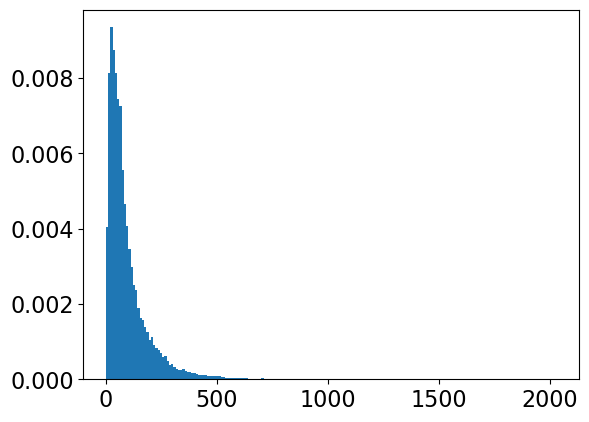

In [43]:
# Distribution of counts of each id
x, bins, p =plt.hist(counts, bins=200, density=True)
plt.show()

In [77]:
# def metric_hubness(dataset, k):
#     _, counts = np.unique(dataset.values[:,:k], return_counts=True)
#     s = ((counts - np.mean(counts))**3)/(np.std(counts)**3)
#     return np.mean(s)

# def get_popularity_bias_metric(topIdsDataset, popularityDataset,  metric):
#     bias_metric = []
#     for query in topIdsDataset.index.values:
#         recommended_documents = topIdsDataset.loc[query].values
#         recommended_documents_popularity = popularityDataset.loc[recommended_documents].values
#         mean_recommended_documents_popularity = metric(recommended_documents_popularity)
#         # Only the popularity of the query? Is this correct?
#         query_popularity = popularityDataset.loc[query].item()
#         if query_popularity != 0:
#             popularity_bias = (mean_recommended_documents_popularity - query_popularity) / query_popularity
#         else:
#             popularity_bias = 0
#         bias_metric.append(popularity_bias)
        
#     return np.array(bias_metric)

In [44]:
# Test hubness metric
hubness_10 = metric_hubness(top_cosine_tfidf, 10)
hubness_100 = metric_hubness(top_cosine_tfidf, 100)
print(hubness_10, hubness_100)

4.6873693382968495 4.214573570018961


In [78]:
# The same as generate_MAP_MRR_NDCG_file, but with all the metrics
# def get_metrics_file(file, datasets, genres,relevantNumbers,spotifyData):
#     if exists(file ):
#         metrics_datasets = pd.read_csv(file, index_col=0)
#     else:
        
#         MAP_100 = np.zeros((len(datasets.items())))
#         MRR_100 = np.zeros((len(datasets.items())))
#         MeanNDCG_100 = np.zeros((len(datasets.items())))
#         MAP_10 = np.zeros((len(datasets.items())))
#         MRR_10 = np.zeros((len(datasets.items())))
#         MeanNDCG_10 = np.zeros((len(datasets.items())))
        
#         bias_values = np.zeros((len(datasets.items())))
#         hubness_10 = np.zeros((len(datasets.items())))
#         hubness_100 = np.zeros((len(datasets.items())))
    
#         i = 0
#         for value in datasets.values():
#             MAP_100[i], MRR_100[i], MeanNDCG_100[i] = getMetrics(value, 100, genres, relevantNumbers)
#             MAP_10[i], MRR_10[i], MeanNDCG_10[i] = getMetrics(value, 10, genres, relevantNumbers)
#             bias_values[i] = np.median(get_popularity_bias_metric(value, spotifyData, np.mean))
#             hubness_10[i] = metric_hubness(value, 10)
#             hubness_100[i] = metric_hubness(value, 100)
#             i+=1
                  
#         metrics_datasets =pd.DataFrame(
#             np.column_stack((MAP_10,MAP_100, MRR_10,MRR_100,MeanNDCG_10,MeanNDCG_100,bias_values,hubness_10,hubness_100)), 
#             index=datasets.keys(), 
#             columns=['MAP_10','MAP_100','MRR_10','MRR_100','Mean NDCG_10','Mean NDCG_100','%DeltaMean','S10', 'S100'])
#         metrics_datasets.to_csv(file)
        
#     return metrics_datasets

In [45]:
def min_value1(s):
    is_max = s == s.min()
    return ['color: red' if v else '' for v in is_max]

def highlight1(s,p, style):
    is_max = s.isin(s.nlargest(3).iloc[[p]])
    return [style if v else '' for v in is_max]

def style_df1(dataframe):
    return dataframe.style.\
        apply(highlight1,p=0,style='font-weight: bold;  ').\
        apply(highlight1,p=1,style='text-decoration: underline;  ').\
        apply(min_value1)

### Metrics for individual features with cosine and jaccard similarities

In [40]:
## This ones do not calculate popularity bias and hubness

# metrics_cosine = generate_MAP_MRR_NDCG_file('./data/df_metrics_cosine_individual.csv', cosine_df, genres, relevant_results_by_id)
# metrics_jaccard = generate_MAP_MRR_NDCG_file('./data/df_metrics_jaccard_individual.csv', jaccard_df, genres, relevant_results_by_id)

In [46]:
# This ones include the hubness and popularity bias
metrics_cosine_individual = get_metrics_file('./data/df_allmetrics_cosine_individual.csv',
                                           cosine_df,
                                           genres,
                                           relevant_results_by_id,spotify_data)
metrics_jaccard_individual = get_metrics_file('./data/df_allmetrics_jaccard_individual.csv',
                                            jaccard_df, 
                                            genres, 
                                            relevant_results_by_id,
                                            spotify_data)

In [47]:
# Metrics for individual features with cosine similarity
metrics_cosine_individual

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538468,0.468318,0.597873,0.602863,0.445806,0.445989,0.021471,0.323246,0.094932
tfidf,0.613005,0.533717,0.675660,0.679565,0.522946,0.509408,0.062432,4.687369,4.214574
word2vec,0.620418,0.531777,0.688515,0.691910,0.526673,0.505861,0.102609,16.733727,10.633337
bert,0.662683,0.582197,0.724922,0.727865,0.580295,0.558143,0.057727,12.455223,6.382306
mfcc_bow,0.686826,0.611884,0.745529,0.748227,0.609634,0.589270,0.057407,3.542412,2.684883
mfcc_stats,0.664758,0.590062,0.723587,0.726534,0.585111,0.566645,0.044250,4.471769,3.898211
essentia,0.589588,0.518582,0.651804,0.655771,0.500432,0.496907,0.019444,-0.049851,-3.908131
blf_delta_spectral,0.660296,0.580015,0.724785,0.727699,0.576541,0.556345,0.041429,5.728301,4.060359
blf_correlation,0.659284,0.576151,0.721592,0.724590,0.575718,0.550553,0.097241,6.644647,5.174368
blf_logfluc,0.684356,0.606021,0.743860,0.746583,0.606172,0.580933,0.046486,3.961619,2.879824


In [48]:
metrics_jaccard_individual

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538468,0.468318,0.597873,0.602863,0.445806,0.445989,0.021471,0.323246,0.094932
tfidf,0.613004,0.533717,0.675660,0.679565,0.522945,0.509408,0.062432,4.687369,4.214574
word2vec,0.624759,0.539065,0.691396,0.694771,0.533132,0.513644,0.098857,14.727740,9.085890
bert,0.661879,0.581193,0.724954,0.727930,0.579012,0.557018,0.054643,9.010342,5.461563
mfcc_bow,0.687474,0.612715,0.746112,0.748768,0.610339,0.590168,0.054722,3.463352,2.635899
mfcc_stats,0.664174,0.590425,0.722392,0.725343,0.584875,0.567424,0.075000,4.101405,3.328198
essentia,0.592352,0.523702,0.652931,0.656900,0.504334,0.502508,0.016750,-0.001486,-1.643566
blf_delta_spectral,0.661564,0.583388,0.724989,0.727925,0.578844,0.560056,0.038000,4.718627,3.283704
blf_correlation,0.670713,0.590480,0.732433,0.735292,0.590371,0.565986,0.074250,6.862538,5.170359
blf_logfluc,0.686698,0.608773,0.745404,0.748034,0.608981,0.584111,0.056842,3.339564,2.356133


### Metrics for early fusion features with cosine and jaccard similarities

In [49]:
# If the file exists already only pass an empty object as second parameter get_metrics_file(file, {}, genres, spotify_data)
metrics_cosine_earlyfusion= get_metrics_file('./data/df_allmetrics_cosine_earlyfusion.csv',
                                                cosine_fusion_datasets,
                                                genres,
                                                 relevant_results_by_id,
                                                spotify_data)

metrics_jaccard_earlyfusion = get_metrics_file('./data/df_allmetrics_jaccard_earlyfusion.csv',
                                               jaccard_fusion_datasets,
                                               genres,
                                                relevant_results_by_id,
                                               spotify_data)

In [50]:
metrics_cosine_earlyfusion

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538468,0.468318,0.597873,0.602863,0.445806,0.445989,0.021471,0.323246,0.094932
bert_blf_spectral_resnet,0.709969,0.588260,0.773099,0.775903,0.612063,0.550443,0.051333,5.940676,4.368241
bert_blf_spectral_incp,0.703842,0.584462,0.767435,0.770270,0.605639,0.547033,0.050000,10.312802,7.806865
bert_mfcc_bow_resnet,0.729101,0.611167,0.791443,0.793982,0.637839,0.574619,0.062143,6.194223,4.375171
bert_mfcc_bow_incp,0.742106,0.634882,0.802869,0.805143,0.656935,0.602571,0.070833,9.555807,7.299239
bert_blf_logfluc_resnet,0.684353,0.606024,0.743885,0.746607,0.606157,0.580945,0.046571,3.959753,2.879721
bert_blf_logfluc_incp,0.684355,0.606017,0.743882,0.746607,0.606164,0.580934,0.046486,3.960009,2.879688
tfidf_blf_spectral_resnet,0.709934,0.588238,0.773073,0.775879,0.612025,0.550424,0.051250,5.941250,4.368690
tfidf_blf_spectral_incp,0.703593,0.584259,0.767169,0.770008,0.605326,0.546814,0.050286,10.306988,7.806771
tfidf_mfcc_bow_resnet,0.729073,0.611143,0.791484,0.794020,0.637807,0.574594,0.062162,6.196735,4.375969


In [51]:
style_df1(metrics_jaccard_earlyfusion)

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538468,0.468318,0.597873,0.602863,0.445806,0.445989,0.021471,0.323246,0.094932
bert_essentia_vgg19,0.592254,0.523686,0.652758,0.656715,0.504315,0.502496,0.016757,0.001424,-1.643794
bert_essentia_resnet,0.592254,0.523686,0.652758,0.656715,0.504315,0.502496,0.016757,0.001424,-1.643794
bert_blf_logfluc_vgg19,0.686729,0.608819,0.745335,0.747959,0.609043,0.584149,0.057059,3.335601,2.355292
bert_blf_logfluc_resnet,0.686699,0.608787,0.745402,0.748031,0.608987,0.584117,0.056905,3.339653,2.356179
bert_mfcc_stats_vgg19,0.691774,0.605502,0.751962,0.754627,0.609612,0.579650,0.095882,6.557093,4.972693
bert_mfcc_stats_resnet,0.683229,0.603326,0.742604,0.745422,0.602809,0.578777,0.078667,5.868815,3.970499
tfidf_essentia_vgg19,0.592266,0.523696,0.652687,0.656646,0.504355,0.502500,0.016765,0.001958,-1.643632
tfidf_essentia_resnet,0.592266,0.523696,0.652687,0.656646,0.504355,0.502500,0.016765,0.001958,-1.643632
tfidf_blf_logfluc_vgg19,0.686738,0.608818,0.745353,0.747980,0.609038,0.584149,0.057059,3.335832,2.355327


### Metrics for early fusion PCA reduced features with cosine and jaccard similarities

### Metrics for late fusion features with cosine and jaccard similarities

## Precision - Recall Plots

In [52]:
# def Precision(dfTopIds, topNumber, returnMeanOfValues, genres, relevantNumbers):
    
#     precision = np.zeros((dfTopIds.shape[0], topNumber))
#     recall = np.zeros((dfTopIds.shape[0], topNumber))
#     precision_max = np.zeros((dfTopIds.shape[0], topNumber))
    
#     for idx,queryId in tqdm(enumerate(dfTopIds.index.values)):
        
#         topIds = dfTopIds.loc[queryId].values[:topNumber]
#         querySongGenres = genres.loc[[queryId], 'genre'].values[0]
#         topSongsGenres  = genres.loc[topIds, 'genre'].values
#         relevant_results = [isResultRelevant(querySongGenres, songGenre) for songGenre in topSongsGenres]
        
#         #Relevants in all set
#         REL =relevantNumbers.loc[queryId].values

#         if REL != 0: # Case when there is no relevant result in the top@K
#             precision[idx] = np.divide(np.cumsum(relevant_results,axis=0), np.arange(1,topNumber+1))
#             recall[idx] = np.divide(np.cumsum(relevant_results,axis=0), REL)
#             precision_max[idx] = [ np.max(precision[idx,i:]) for i,val in enumerate(precision[idx])]

#     if returnMeanOfValues:
#         return np.mean(precision, axis=0), np.mean(recall, axis=0), np.mean(precision_max, axis=0)
#     return precision, recall, precision_max

In [53]:
_,_, _ = Precision(top_cosine_tfidf.iloc[:3], 10, False, genres, relevant_results_by_id)

3it [00:00, 897.95it/s]


In [54]:
p, r, p_max = Precision(top_cosine_tfidf, 100, False, genres, relevant_results_by_id)
p1, r1, p1_max = Precision(top_cosine_word2vec, 100, False, genres, relevant_results_by_id)

68641it [01:21, 846.86it/s]
68641it [01:20, 851.02it/s]


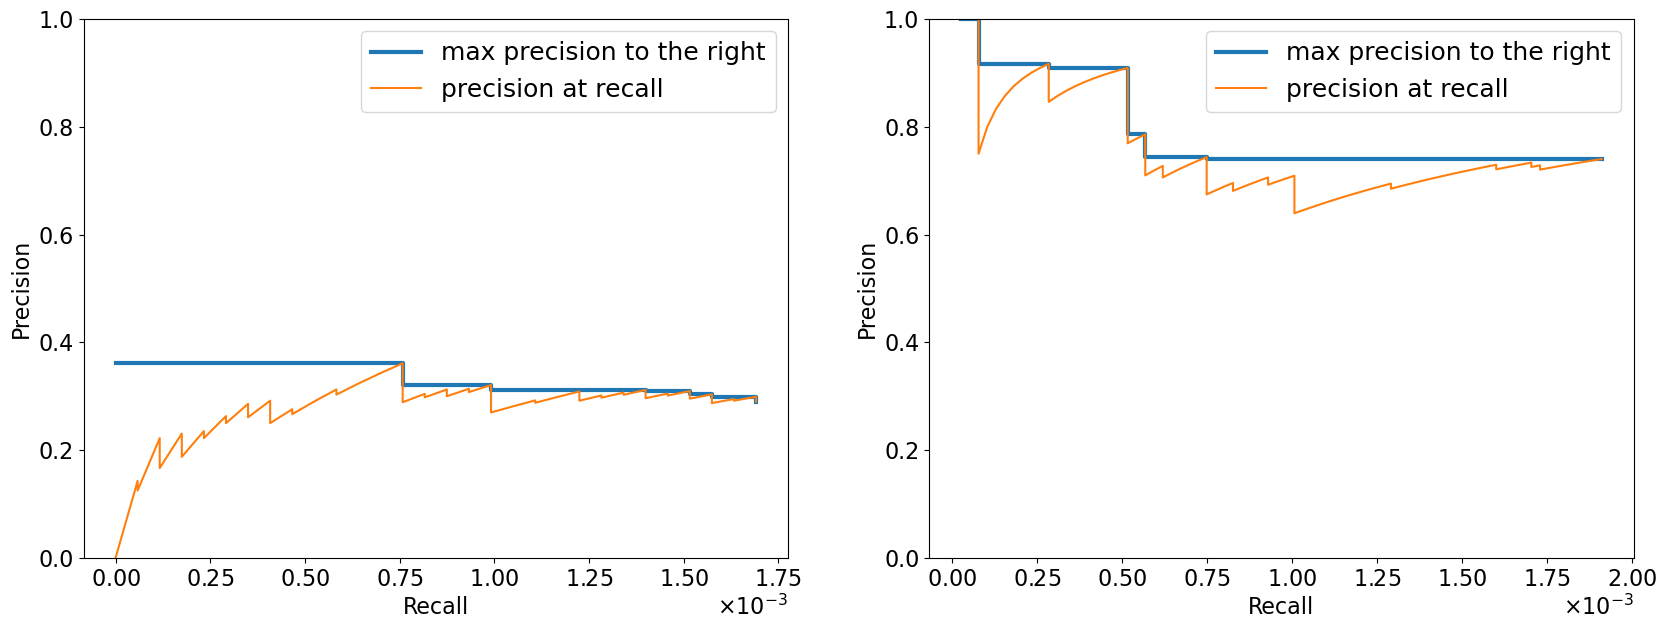

In [55]:
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

index_test = 2
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,7))
axs[0].plot(r[index_test], p_max[index_test], label='max precision to the right', linewidth=3)
axs[0].plot(r[index_test], p[index_test], label='precision at recall')
axs[0].legend()
axs[0].set_xlabel('Recall')
axs[0].set_ylabel('Precision')
axs[0].set_ylim(0,1)
axs[0].xaxis.set_major_formatter(formatter) 
axs[1].plot(r1[index_test], p1_max[index_test],  label='max precision to the right', linewidth=3)
axs[1].plot(r1[index_test], p1[index_test], label='precision at recall' )
axs[1].legend()
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_ylim(0,1)
axs[1].xaxis.set_major_formatter(formatter) 
plt.show()

In the figure above we plot for a single querie how looks the precision-recall using precision and max precision to the right with differente features.

In the next plot we can see the mean of precision-recall plots in all the queries using the max precision to the right.

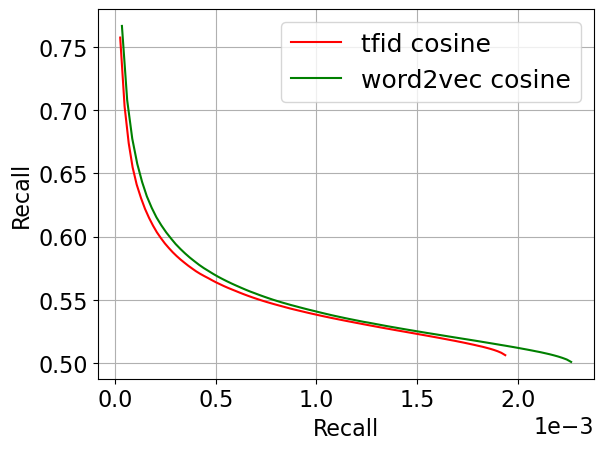

In [56]:
plt.plot(np.mean(r, axis=0), np.mean(p_max, axis=0), color='r', label='tfid cosine')
plt.plot(np.mean(r1, axis=0), np.mean(p1_max, axis=0), color='g', label='word2vec cosine')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.grid()
plt.xlabel("Recall")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [57]:
# def get_precision_data(f_p, f_r, f_p_max, datasets, genres, relevant_by_id):
#     if (exists(f_p) and  exists(f_r) and exists(f_p_max)):
#         P = pd.read_csv(f_p, index_col=0).to_numpy()
#         R = pd.read_csv(f_r, index_col=0).to_numpy()
#         P_max = pd.read_csv(f_p_max, index_col=0).to_numpy()
#     else:
#         i = 0
#         P = np.zeros((len(datasets.items()), 100))
#         R = np.zeros((len(datasets.items()), 100))
#         P_max = np.zeros((len(datasets.items()), 100))
#         for value in datasets.values():
#             P[i], R[i], P_max[i] = Precision(value, 100, True, genres, relevant_by_id)
#             i += 1  

#         pd.DataFrame(P, index=datasets.keys()).to_csv(f_p)
#         pd.DataFrame(R, index=datasets.keys()).to_csv(f_r)
#         pd.DataFrame(P_max, index=datasets.keys()).to_csv(f_p_max)
        
#     return P,R,P_max

In [58]:
cosine_P, cosine_R, cosine_P_max = get_precision_data('./data/cosine_precision_data_individual.csv',
                                                      './data/cosine_recall_data_individual.csv',
                                                      './data/cosine_max_precision_data_individual.csv',
                                                        cosine_df,
                                                        genres,
                                                        relevant_results_by_id
                                                        )

In [59]:
jaccard_P, jaccard_R, jaccard_P_max = get_precision_data('./data/jaccard_precision_data_individual.csv',
                                                      './data/jaccard_recall_data_individual.csv',
                                                      './data/jaccard_max_precision_data_individual.csv',
                                                         jaccard_df,
                                                         genres,
                                                         relevant_results_by_id
                                                        )

In [60]:
cosine_early_P, cosine_early_R, cosine_early_P_max  = get_precision_data(
    './data/cosine_precision_data_earlyfusion.csv',
    './data/cosine_recall_data_earlyfusion.csv',
    './data/cosine_max_precision_data_earlyfusion.csv',
    cosine_fusion_datasets,
    genres,
    relevant_results_by_id)

In [61]:
jaccard_early_P, jaccard_early_R, jaccard_early_P_max= get_precision_data(
    './data/jaccard_precision_data_earlyfusion.csv',
    './data/jaccard_recall_data_earlyfusion.csv',
    './data/jaccard_max_precision_data_earlyfusion.csv',
    jaccard_fusion_datasets,
    genres,
    relevant_results_by_id)

Text(0.5, 0.98, 'Comparison between Precision-Recall using Cosine and Jaccard Similarity')

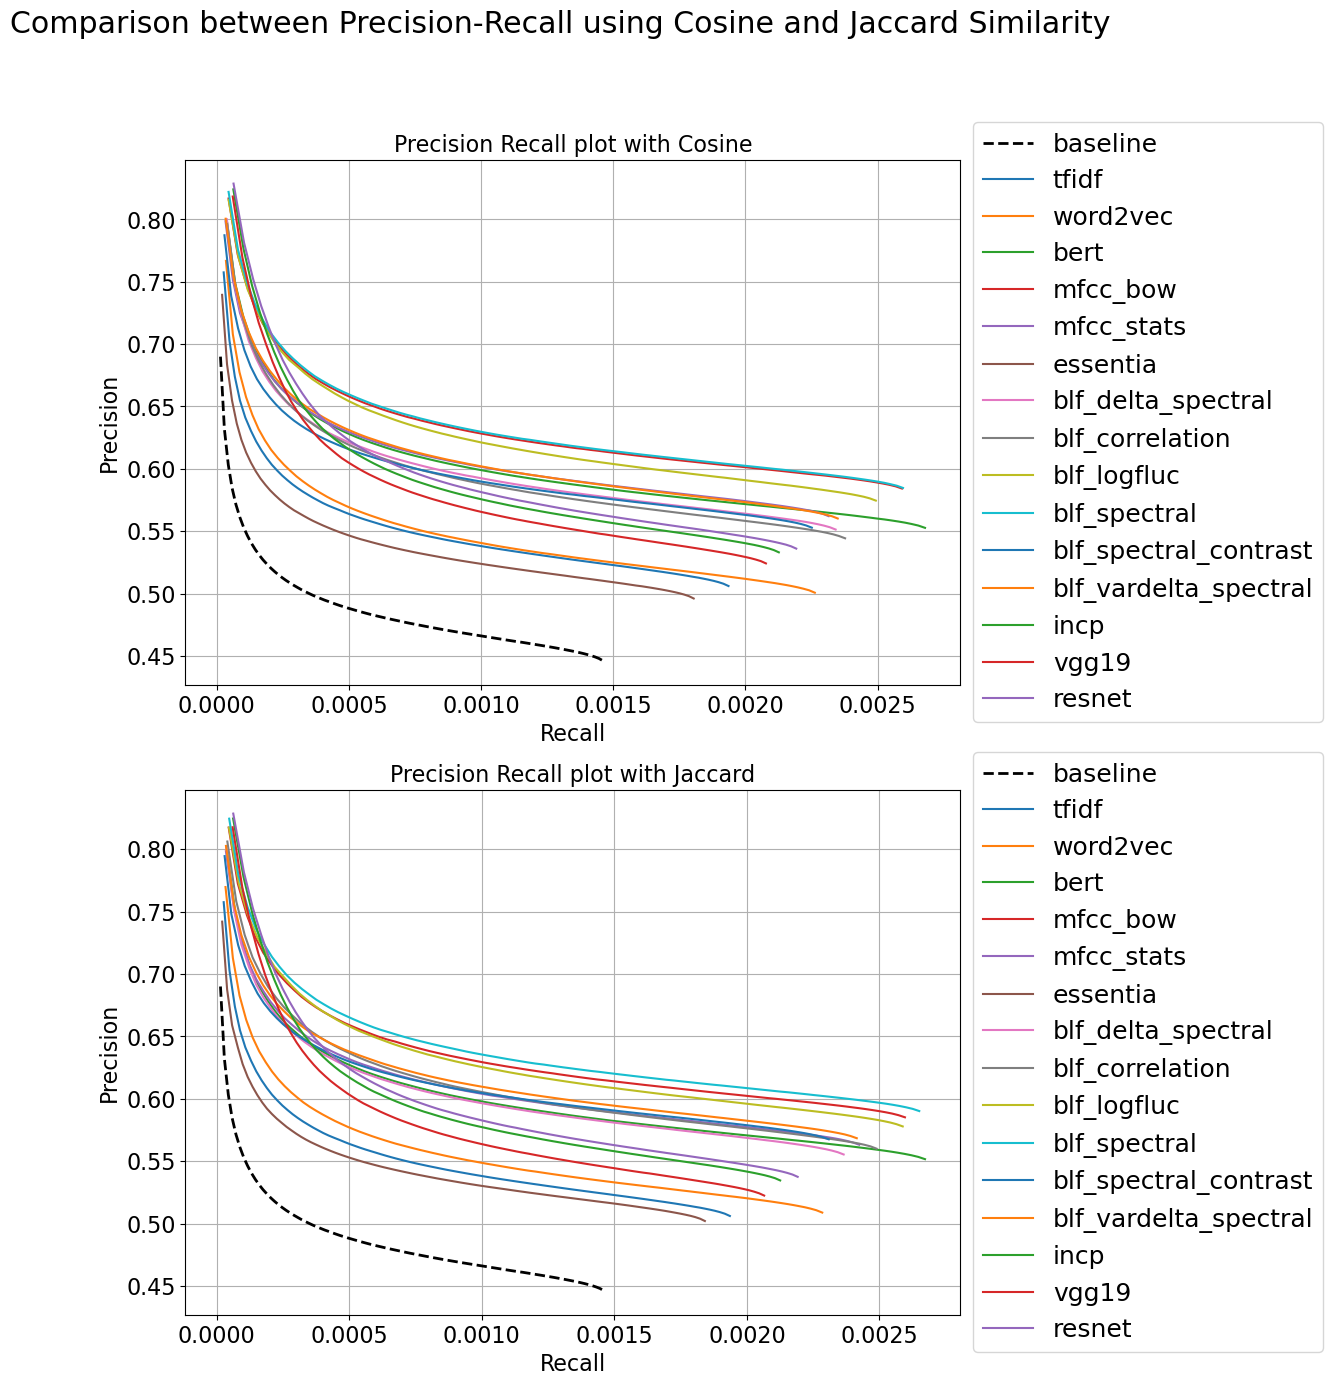

In [62]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(10, 15))

for i,key in enumerate(datasets_keys):
    if (key == 'baseline'):
        axs[0].plot(cosine_R[i], cosine_P_max[i], label=key, linestyle='dashed', color='black', linewidth=2)
    else:
        axs[0].plot(cosine_R[i], cosine_P_max[i], label=key)

axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision Recall plot with Cosine")  # Add a title to the axes.
# axs[0].set_aspect('equal')
# axs[0].set_ylim(0.3,1) 
# ax.set_xlim(0,1) 
axs[0].grid(True)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for i,key in enumerate(datasets_keys):
    if (key == 'baseline'):
        axs[1].plot(jaccard_R[i], jaccard_P_max[i], label=key, linestyle='dashed', color='black', linewidth=2)
    else:
        axs[1].plot(jaccard_R[i], jaccard_P_max[i], label=key)

axs[1].set_xlabel("Recall")
axs[1].set_ylabel("Precision")
axs[1].set_title("Precision Recall plot with Jaccard")  # Add a title to the axes.
# axs[1].set_aspect('equal')
# axs[1].set_ylim(0.3,1) 
axs[1].grid(True)
axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle('Comparison between Precision-Recall using Cosine and Jaccard Similarity')

#### Comparing between lyrics, audio and video

In [63]:
def plot_lyrics_audio_video_precision_curves(lyrics, audio, video, data, keys, name):
    
    labels = datasets_keys
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(10, 20))
    R, P_max = data

    # Lyrics
    for i in range(1,4):
        if keys[i] in lyrics:
            axs[0].plot(R[i], P_max[i], label=keys[i])
    axs[0].plot(R[0], P_max[0], label='baseline', linestyle='dashed', color='black', linewidth=2)
    axs[0].grid(True)
    axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title("Precision vs Recall - Lyrics features")

    for i in range(4,13):
        if(keys[i+1] in audio):
            axs[1].plot(R[i],  P_max[i], label=keys[i])
    axs[1].plot(R[0], P_max[0], label='baseline', linestyle='dashed', color='black', linewidth=2)

    axs[1].grid(True)
    axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")
    axs[1].set_title("Precision  vs Recall - Audio features")

    for i in range(13,16):
        if(keys[i] in video):
            axs[2].plot(R[i], P_max[i], label=keys[i])
    axs[2].plot(R[0], P_max[0], label='baseline', linestyle='dashed', color='black', linewidth=2)
    axs[2].grid(True)
    axs[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[2].set_xlabel("Recall")
    axs[2].set_ylabel("Precision")
    axs[2].set_title("Precision vs Recall  - Video features")

    fig.suptitle(f'Comparison between Lyrics, Audio and Video Using {name}')
    
    return fig,axs
    

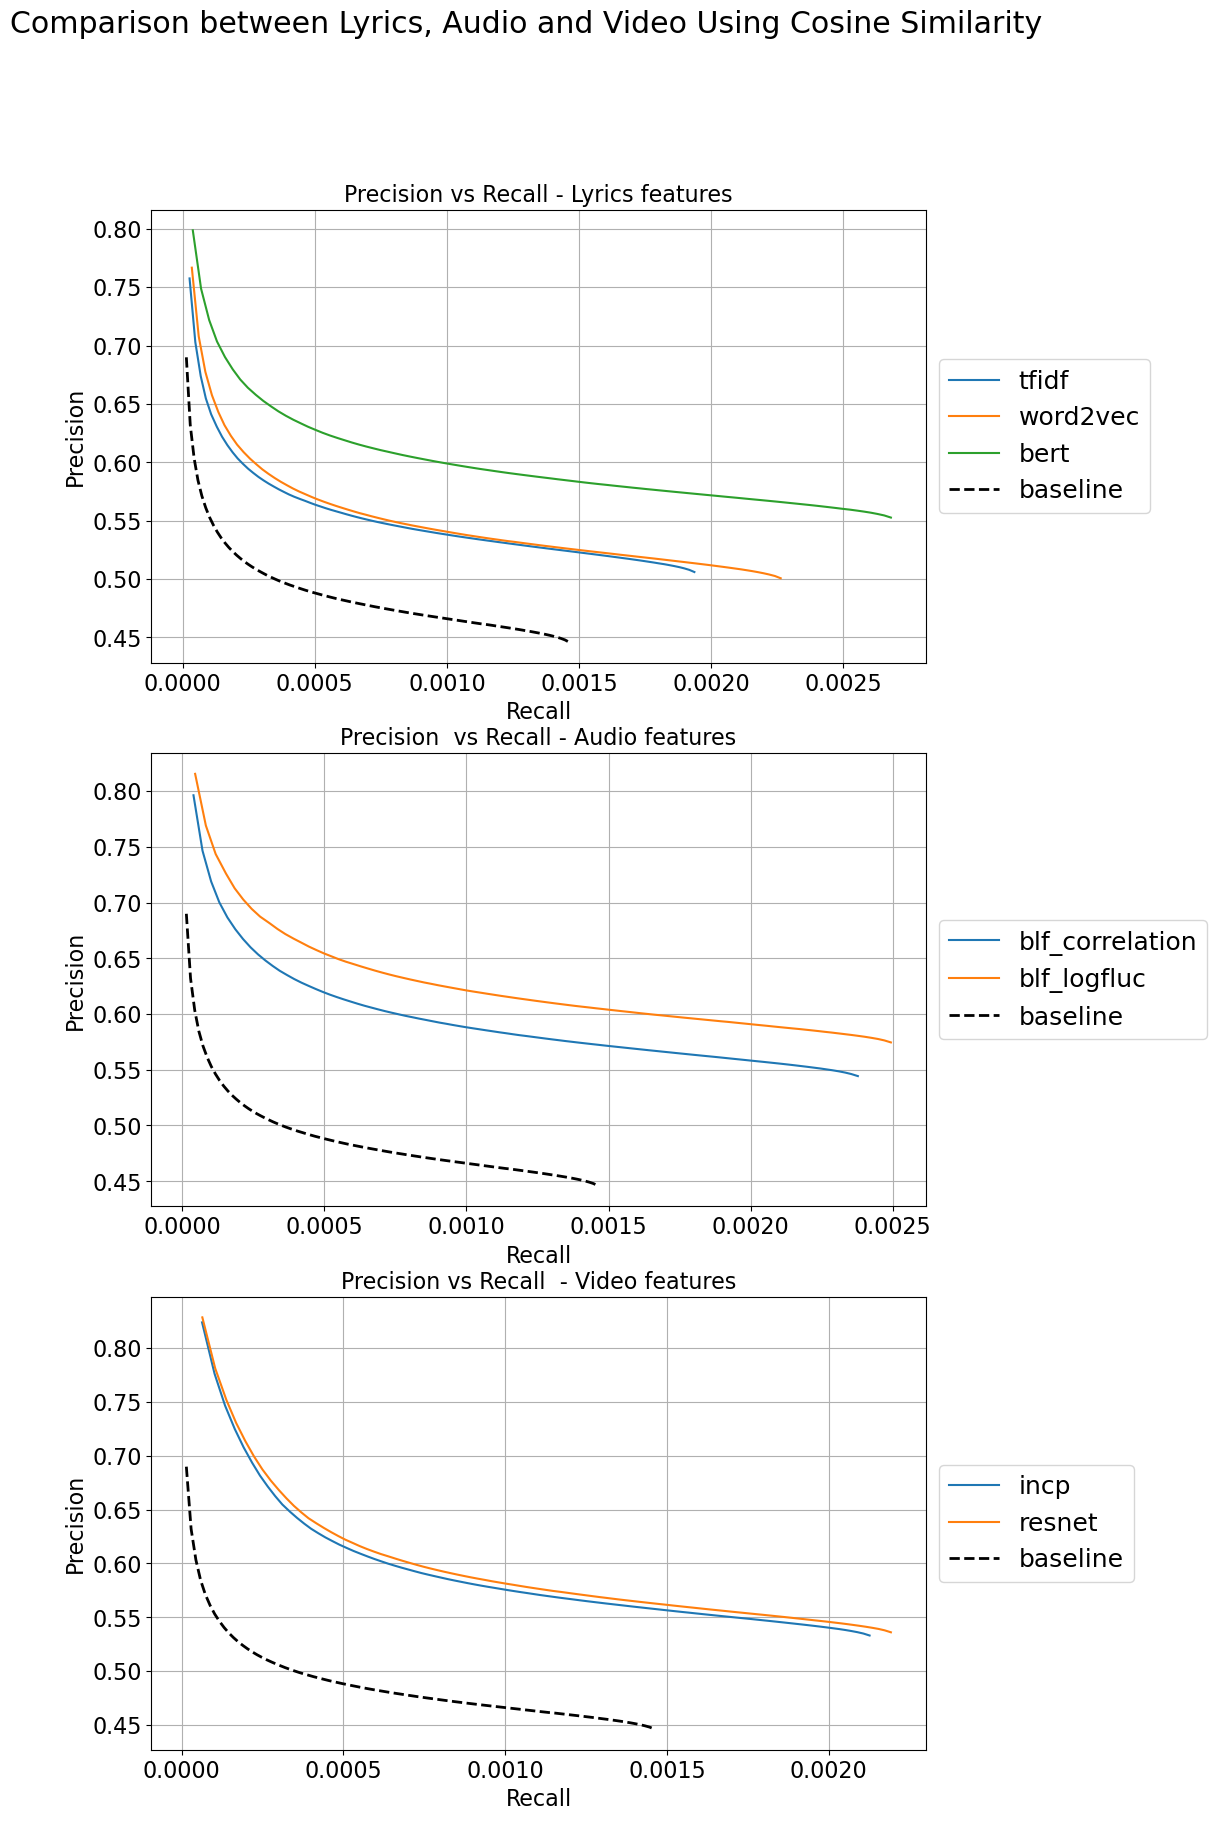

In [64]:
lyrics = ["tfidf", "word2vec", "bert"]
audio = ["blf_spectral", "mfcc_bow", "blf_logfluc"]
video = [ "incp",  "resnet"]
    
fig, axs = plot_lyrics_audio_video_precision_curves(lyrics, audio, video, 
                                                    (cosine_R, cosine_P_max),  
                                                    datasets_keys, 
                                                    "Cosine Similarity")
plt.show()

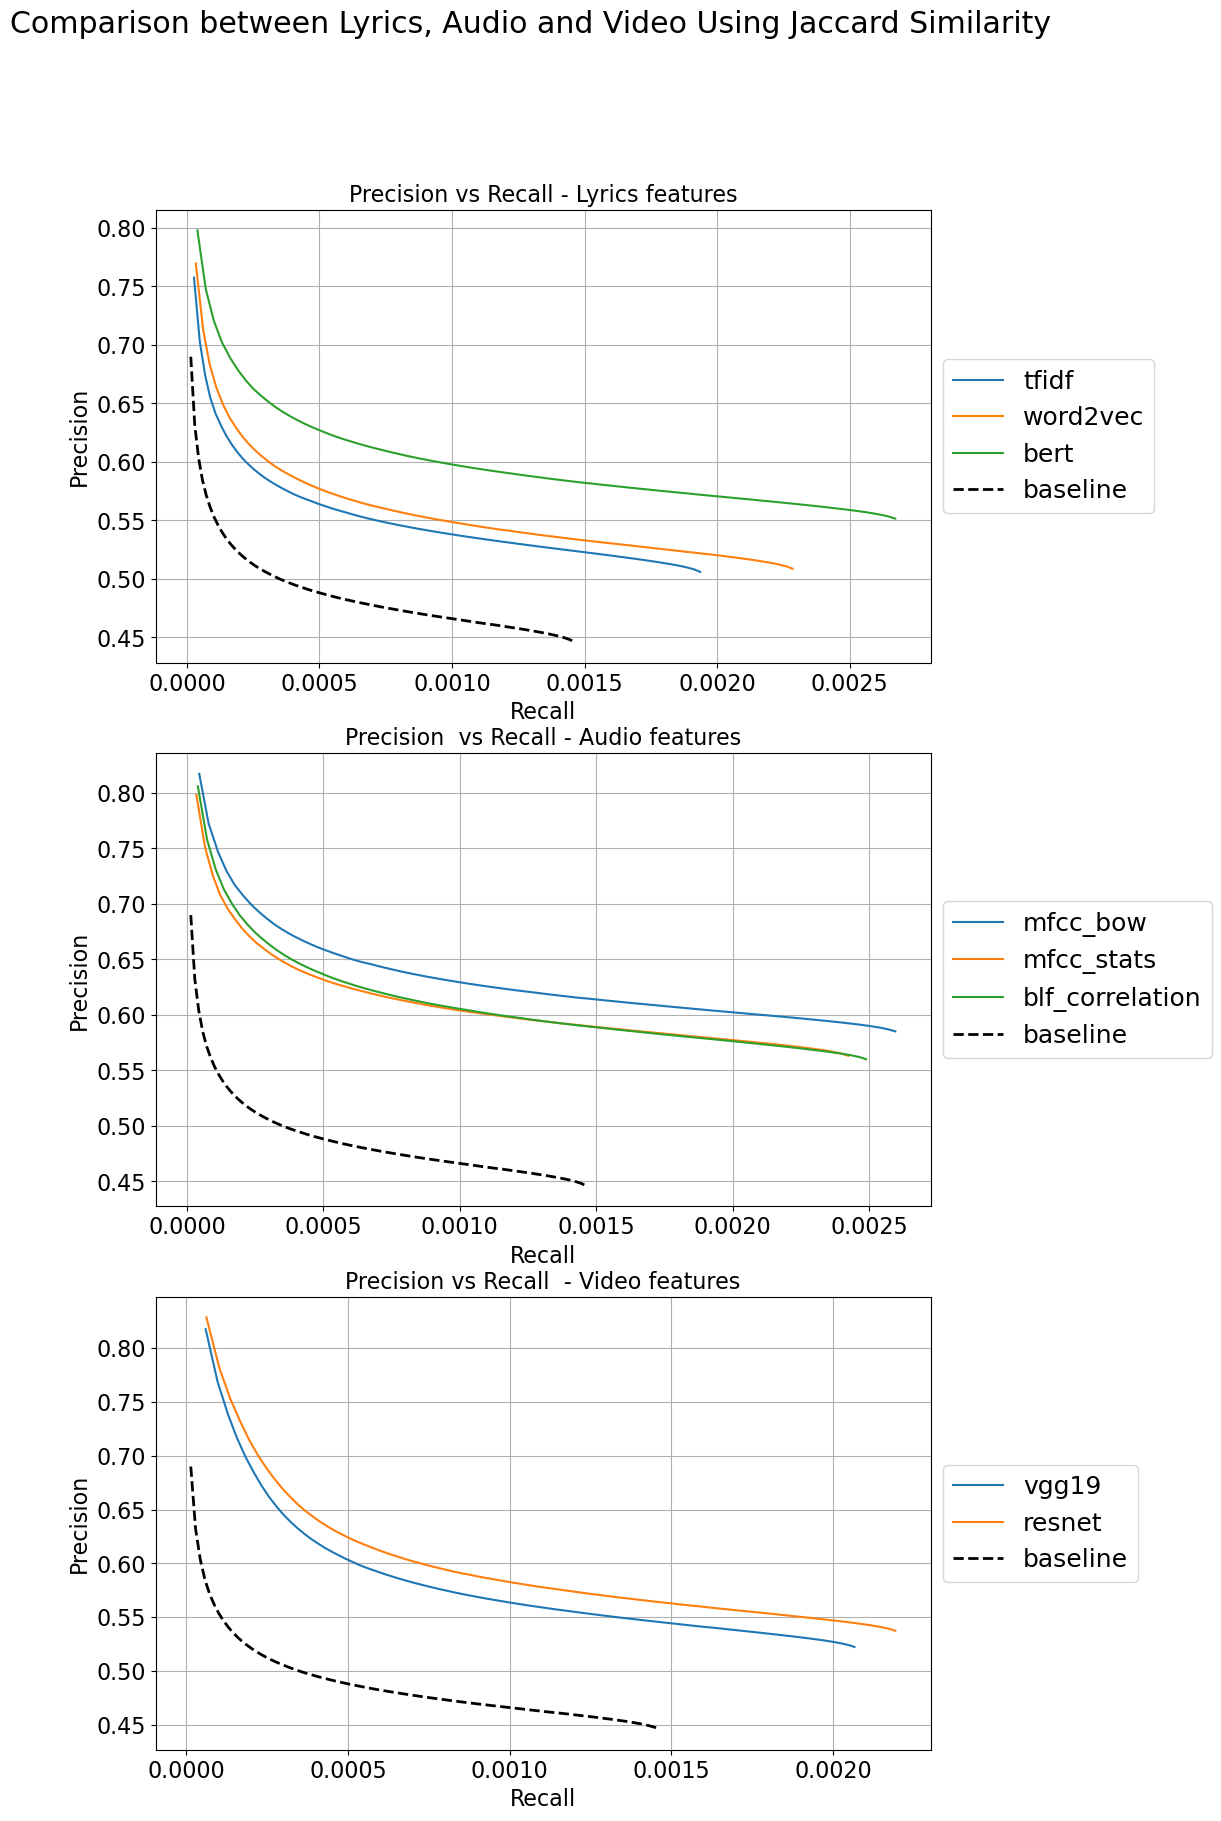

In [65]:
lyrics = ["tfidf", "word2vec", "bert"]
audio = ["mfcc_stats", "essentia", "blf_logfluc"]
video = [ "vgg19", "resnet"]

fig, axs = plot_lyrics_audio_video_precision_curves(lyrics, audio, video, 
                                                    (jaccard_R, jaccard_P_max),  
                                                    datasets_keys, 
                                                    "Jaccard Similarity")
plt.show()

Text(0.5, 1.0, 'Precision Recall - Comparing Cosine in Early Fusion')

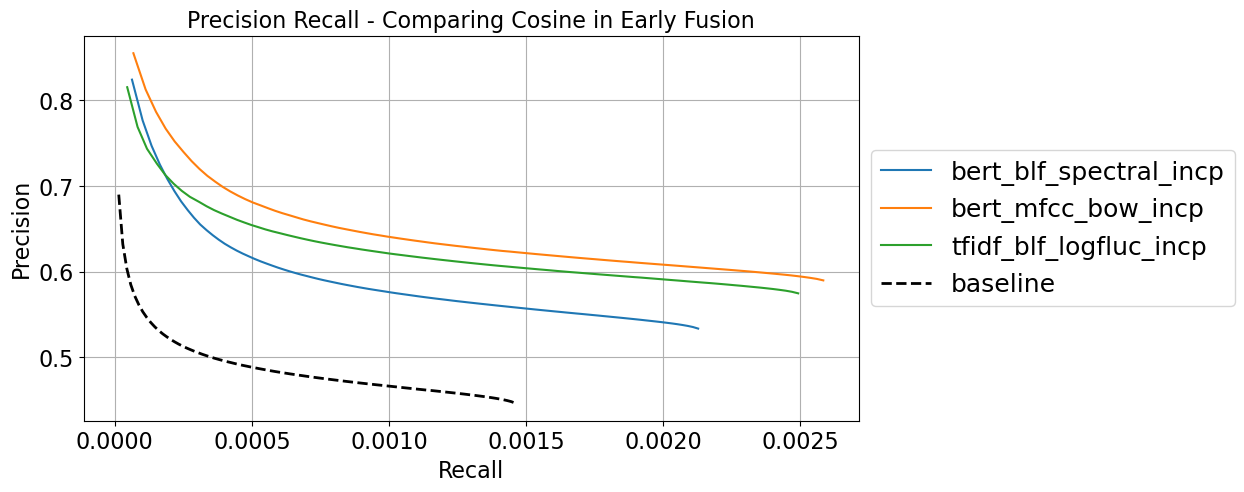

In [73]:
fig, axs = plt.subplots( figsize=(10, 5))

labels = cosine_fusion_keys
include = [ 'bert_mfcc_bow_incp', 'bert_blf_spectral_incp', 'tfidf_blf_logfluc_incp']
for i in range(1,len(labels)):
    if(labels[i]  in include):
        axs.plot(cosine_early_R[i], cosine_early_P_max[i], label=f'{labels[i]}')
        

axs.plot(cosine_early_R[0], cosine_early_P_max[0], label='baseline', linestyle='dashed', color='black', linewidth=2)
axs.grid(True)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel("Recall")
axs.set_ylabel("Precision")
axs.set_title("Precision Recall - Comparing Cosine in Early Fusion")

Text(0.5, 1.0, 'Precision Recall - Comparing Jaccard in Early Fusion')

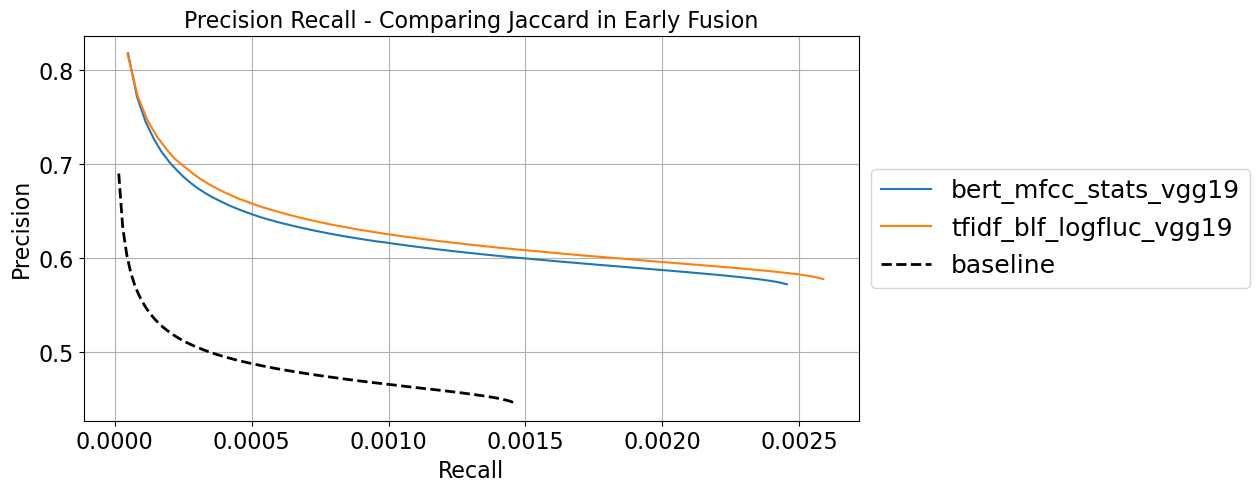

In [68]:
fig, axs = plt.subplots( figsize=(10, 5))

labels = jaccard_fusion_keys
include = ['tfidf_blf_logfluc_vgg19','bert_mfcc_stats_vgg19']
for i in range(1,len(labels)):
    if(labels[i]  in include):
        axs.plot(jaccard_early_R[i], jaccard_early_P_max[i], label=f'{labels[i]}')
        

axs.plot(jaccard_early_R[0], jaccard_early_P_max[0], label='baseline', linestyle='dashed', color='black', linewidth=2)
axs.grid(True)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel("Recall")
axs.set_ylabel("Precision")
axs.set_title("Precision Recall - Comparing Jaccard in Early Fusion")

Text(0.5, 1.0, 'Precision Recall - Comparing Cosine and Jaccard Early Fusion')

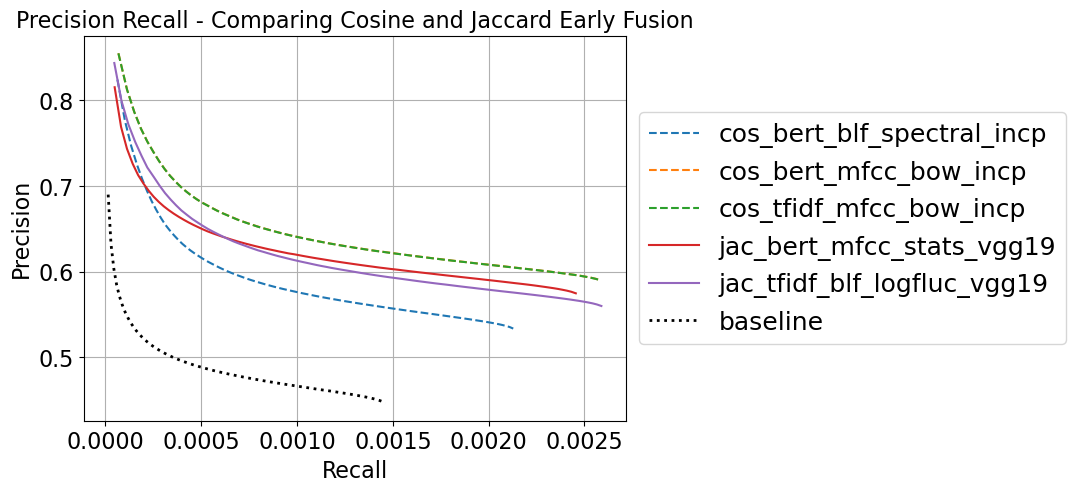

In [69]:
fig, axs = plt.subplots( figsize=(7, 5))

labels = cosine_fusion_keys
include = ["bert_mfcc_bow_incp", "tfidf_mfcc_bow_incp", "bert_blf_spectral_incp"]
for i in range(len(labels)):
    if(labels[i]  in include):
        axs.plot(cosine_early_R[i], cosine_early_P_max[i], label=f'cos_{labels[i]}', linestyle='dashed')
        
labels = jaccard_fusion_keys
include = ['tfidf_blf_logfluc_vgg19','bert_mfcc_stats_vgg19']
for i in range(len(labels)):
    if(labels[i]  in include):
        axs.plot(jaccard_early_R[i], cosine_early_P_max[i], label=f'jac_{labels[i]}', )

axs.plot(cosine_early_R[0], cosine_P_max[0], label='baseline', linestyle='dotted', color='black', linewidth=2)
axs.grid(True)
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs.set_xlabel("Recall")
axs.set_ylabel("Precision")
axs.set_title("Precision Recall - Comparing Cosine and Jaccard Early Fusion")

## TO REVIEW 

In [135]:
# If the file exists already only pass an empty object as second parameter get_metrics_file(file, {}, genres, spotify_data)
# metrics_early_fusion_jaccard = get_metrics_file(file_metrics_earlyfusion_jaccard, jaccard_fusion_datasets, genres, spotify_data)

In [21]:
# style_df1(metrics_late_fusion_jaccard)

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538928,0.468788,0.598932,0.603907,0.647442,0.702656,0.022000,0.323246,0.094932
bert_essentia_vgg19,0.638390,0.557673,0.704025,0.707116,0.732624,0.769645,0.018125,6.761615,4.952444
bert_essentia_resnet,0.638321,0.558235,0.702812,0.705874,0.732972,0.770014,0.026667,7.066268,5.131827
bert_blf_logfluc_vgg19,0.647830,0.560406,0.719201,0.722293,0.739574,0.772035,0.019118,190.958193,49.734176
bert_blf_logfluc_resnet,0.645550,0.560490,0.714102,0.717183,0.738316,0.771919,0.027568,177.348571,37.503021
bert_mfcc_stats_vgg19,0.638372,0.557660,0.704028,0.707109,0.732640,0.769679,0.018947,6.749202,4.939197
bert_mfcc_stats_resnet,0.638372,0.558233,0.702939,0.706003,0.732984,0.770047,0.027826,7.038499,5.119624
tfidf_essentia_vgg19,0.613266,0.533877,0.676129,0.680040,0.708667,0.749598,0.063333,4.686198,4.213887
tfidf_essentia_resnet,0.612963,0.533868,0.675328,0.679223,0.708632,0.749586,0.064412,4.770755,4.214798
tfidf_blf_logfluc_vgg19,0.613250,0.533877,0.676100,0.680011,0.708663,0.749596,0.063333,4.686394,4.214018


In [26]:
# top = ["baseline", "bert_blf_logfluc_vgg19",  "bert_blf_logfluc_resnet","bert_mfcc_stats_resnet"]
# metrics_late_fusion_jaccard.loc[top]

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538928,0.468788,0.598932,0.603907,0.647442,0.702656,0.022000,0.323246,0.094932
bert_blf_logfluc_vgg19,0.647830,0.560406,0.719201,0.722293,0.739574,0.772035,0.019118,190.958193,49.734176
bert_blf_logfluc_resnet,0.645550,0.560490,0.714102,0.717183,0.738316,0.771919,0.027568,177.348571,37.503021
bert_mfcc_stats_resnet,0.638372,0.558233,0.702939,0.706003,0.732984,0.770047,0.027826,7.038499,5.119624


In [71]:
# style_df1(metrics_early_fusion_cosine.loc[["baseline", "bert_mfcc_bow_incp", "tfidf_mfcc_bow_incp","bert_blf_spectral_incp"]])

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538928,0.468788,0.598932,0.603907,0.647442,0.702656,0.022000,0.323246,0.094932
bert_mfcc_bow_incp,0.742106,0.634882,0.802869,0.805143,0.811587,0.819520,0.070833,9.555807,7.299239
tfidf_mfcc_bow_incp,0.741965,0.634759,0.802677,0.804956,0.811487,0.819459,0.070833,9.535311,7.301717
bert_blf_spectral_incp,0.703842,0.584462,0.767435,0.770270,0.780445,0.789000,0.050000,10.312802,7.806865


In [51]:
# If the file exists already only pass an empty object as second parameter get_metrics_file(file, {}, genres, spotify_data)
# metrics_early_fusion_cosine = get_metrics_file(file_metrics_earlyfusion_cosine,cosine_fusion_datasets, genres, spotify_data)
# metrics_late_fusion_cosine = get_metrics_file(file_metrics_latefusion_cosine,cosine_fusion_datasets, genres, spotify_data)

In [49]:
metrics_late_fusion_cosine_all = get_metrics_file('./TopIdsFusion/df_metrics_latefusion_cosine_13features.csv',latefusion_df, genres, spotify_data)

100%|███████████████████████████████████| 68641/68641 [01:02<00:00, 1099.48it/s]


In [55]:
top = ["baseline", "bert_mfcc_bow_resnet", "bert_blf_spectral_resnet", "bert_blf_logfluc_resnet"]
style_df1(pd.concat([metrics_late_fusion_cosine.loc[top], metrics_late_fusion_cosine_all]))

,MAP_10,MAP_100,MRR_10,MRR_100,Mean NDCG_10,Mean NDCG_100,%DeltaMean,S10,S100
baseline,0.538928,0.468788,0.598932,0.603907,0.647442,0.702656,0.022000,0.323246,0.094932
bert_mfcc_bow_resnet,0.753010,0.649598,0.814125,0.816161,0.821040,0.828945,0.108519,10.479695,6.428575
bert_blf_spectral_resnet,0.750141,0.646416,0.810614,0.812712,0.818589,0.827105,0.106389,11.493583,6.594030
bert_blf_logfluc_resnet,0.735920,0.628245,0.798590,0.800858,0.807344,0.816467,0.095263,14.847005,7.030452
late_fusion_all,0.542794,0.472480,0.603019,0.607876,0.650907,0.705339,0.017027,6.610749,5.731984


In [63]:
# This is only to style the dataframe, NOT IMPORTANT
def min_value(s, notApply):
    if s.name in notApply:
        return None
    is_max = s == s.min()
#     print(is_max,"\n")
    return ['color: red' if v else '' for v in is_max]

def highlight(s,p,color,notApply):
    if s.name in notApply:
        return None
    is_max = s.isin(s.nlargest(3).iloc[[p]])
    return [f'background-color: {color}' if v else '' for v in is_max]

def skewnessStyleUnder1(s):
    if s.name in ["S10", "S100"]:
        below_1 = np.absolute(s) < 1
        return ['color: blue' if v else '' for v in below_1]
    else:
        return ['' for v in range(len(s))]

def skewnessStyleHigh(s):
    if s.name in ["S10", "S100"]:
        high_value = s == np.absolute(s).max()
        return ['color: red' if v else '' for v in high_value]
    else:
        return ['' for v in range(len(s))]

def negativeDelta(s):
    if s.name in ["%DeltaMean"]:
        negative = s<0
        return ['text-decoration: underline;' if v else '' for v in negative]
    else:
        return ['' for v in range(len(s))]
    
def lowDelta(s):
    if s.name in ["%DeltaMean"]:
        near_zero = s.isin(s.nsmallest(3))
        return ['color:blue;' if v else '' for v in near_zero]
    else:
        return ['' for v in range(len(s))]
    
def highDelta(s):
    if s.name in ["%DeltaMean"]:
        near_zero = s.isin(s.nlargest(3))
        return ['color: red;' if v else '' for v in near_zero]
    else:
        return ['' for v in range(len(s))]

def style_df(dataframe, group2):
    return dataframe.style.\
        apply(highlight,p=0,color='DarkTurquoise  ', notApply=group2).\
        apply(highlight,p=1,color='DarkSeaGreen  ' , notApply=group2).\
        apply(highlight,p=2,color='PaleGreen ' , notApply=group2).\
        apply(min_value, notApply=group2).\
        apply(skewnessStyleUnder1).\
        apply(skewnessStyleHigh).\
        apply(negativeDelta).\
        apply(lowDelta).\
        apply(highDelta)
        

### Cosine Table

In [ ]:
# The one with all features combined
cosine_late_all_P, cosine_late_all_R, cosine_late_all_P_max= get_preicison_data('./TopIdsFusion/df_cosine_lateall_mean_precision_datasets_plot3.csv',
                                                                        './TopIdsFusion/df_cosine_lateall_mean_recall_datasets_plot3.csv',
                                                         './TopIdsFusion/df_cosine_lateall_mean_maxprecision_datasets_plot3.csv',
                                                         latefusion_df,
                                                         genres
                                                        )

In [26]:
cosine_late_P, cosine_late_R, cosine_late_P_max= get_preicison_data(file_cosine_late_mean_precision_datasets,
                                                                        file_cosine_late_mean_recall_datasets,
                                                         file_cosine_late_maxprecision_precision_datasets,
                                                         cosine_fusion_datasets,
                                                         genres
                                                        )

In [27]:
jaccard_late_P, jaccard_late_R, jaccard_late_P_max = get_preicison_data(file_jaccard_late_mean_precision_datasets,
                                                                        file_jaccard_late_mean_recall_datasets,
                                                         file_jaccard_late_maxprecision_precision_datasets,
                                                         jaccard_fusion_datasets,
                                                         genres  )

## Stability of top-k rankings between the retrieval algorithms

There is a function in scipy.stats that computes the kendall tau correlation.
However we founded the problem that this correlation works with sorting the values of the list and from there gets the concordant and discordant pair of values.

The problem is that we have for each query the id as string, and not numbers assigned to the ranks. And the scipy kendall tau function works trough sorting, so when sorting values it was taking in account the first letters of the id and not the rank.

Because of that,  we create a function that computes the kendall tau correlation given the top100 values for the same query in  2 differente features.

Creating for each list all the possible pair of values, and then extracting from it the concordant pairs to calculate the Kendall Tau correlation as defined in Modern Information and Retrieval, Ricardo Baeza-Yates, Berthier Ribeiro-Neto, 2nd Edition, pp.156

$$
    \tau = 1 -  \frac{2\Delta(R_1, R_2)}{K(K-1)}
$$


Where 
- $\Delta(R_1, R_2)$,  the number of discordant pairs in two rankings $R_1, R_2$
    
- $K$, the size of the ranking

In [2]:
def intersection(lst1, lst2):
    # Use of hybrid method
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [3]:
def tauKendall(r1,r2, K):
    possible_pairs_r1 = [(a, b) for idx, a in enumerate(r1) for b in r1[idx + 1:]]
    possible_pairs_r2 = [(a, b) for idx, a in enumerate(r2) for b in r2[idx + 1:]]
    concordant_pairs = intersection(possible_pairs_r1, possible_pairs_r2)
    # 2 times size of concordant pairs because they are repeated in the two rankings
    delta = (K*(K-1)) - (len(concordant_pairs)*2)
    tau = 1 - ((2*delta) / (K*(K-1)))
    return tau

In [4]:
# Tesst with numbers in a list
test_custom = tauKendall([1,2,3,4,5,6,7],[1,3,6,2,7,4,5],7)
test_scipy  = stats.kendalltau([1,2,3,4,5,6,7],[1,3,6,2,7,4,5])
print("Custom Kendall Tau", test_custom, "\nScipy Kendall Tau", test_scipy)

Custom Kendall Tau 0.4285714285714286 
Scipy Kendall Tau SignificanceResult(statistic=0.4285714285714286, pvalue=0.2388888888888889)


In [5]:
# Case of letters
test_custom = tauKendall(['dog','cat','mouse','bird'],['bird', 'mouse', 'cat','dog'],4)
test_scipy  = stats.kendalltau(['dog','cat','mouse','bird'],['bird', 'mouse', 'cat','dog'])
print("Custom Kendall Tau", test_custom, "\nScipy Kendall Tau", test_scipy)

Custom Kendall Tau -1.0 
Scipy Kendall Tau SignificanceResult(statistic=-0.3333333333333334, pvalue=0.75)


In [18]:
test_custom = tauKendall([4,3,5,1,2] ,[2,1,5,3,4],5)
test_scipy  = stats.kendalltau([4,3,5,1,2] ,[2,1,5,3,4])
print("Custom Kendall Tau", test_custom, "\nScipy Kendall Tau", test_scipy)

Custom Kendall Tau -1.0 
Scipy Kendall Tau SignificanceResult(statistic=0.19999999999999998, pvalue=0.8166666666666667)


In [19]:
test_custom = tauKendall([1,2,3,4,5],[5,4,3,2,1],5)
test_scipy  = stats.kendalltau([1,2,3,4,5],[5,4,3,2,1])
print("Custom Kendall Tau", test_custom, "\nScipy Kendall Tau", test_scipy)

Custom Kendall Tau -1.0 
Scipy Kendall Tau SignificanceResult(statistic=-0.9999999999999999, pvalue=0.016666666666666666)


When using strings in lists, the Kendall Tau from scipy doesn't work anymore, because underneath is based on ordering and not counting concordant or discordant pairs like our custom one. That is why we need to use a custom one to get valid results

In [36]:
# # List of possible queries
# queries = top_jaccard_tfidf.index.values
# print(queries.shape)

In [37]:
if (exists(file_corr_all_values_tau_cosine)) and (exists(file_correlations_cosine_tau)):
    correlations_cosine_tau = pd.read_csv(file_correlations_cosine_tau, index_col=0)
    corr_all_values_tau_cosine = pd.read_csv(file_corr_all_values_tau_cosine, index_col=0).to_numpy()
else:    
    correlations_cosine_tau = pd.DataFrame(index=cosine_df.keys(), columns=cosine_df.keys())
    df_cosine_list = list(cosine_df.keys())
    df_cosine_combinations_ = [(a, b) for idx, a in enumerate(df_cosine_list) for b in df_cosine_list[idx + 1:]]
    df_cosine_combinations =list(zip(df_cosine_list, df_cosine_list))
    df_cosine_combinations.extend(df_cosine_combinations_)
    corr_all_values_tau_cosine  = np.zeros((len(df_cosine_combinations), queries.shape[0]))
    print(corr_all_values_tau_cosine.shape)
    
    for i, (df1, df2) in tqdm(enumerate(possible_dataframe_list)):
        for idx,query in enumerate(queries):
            corr_all_values_tau_cosine[i, idx] = tauKendall(cosine_df[df1].loc[query].values, cosine_df[df2].loc[query].values, 100)
        correlations_cosine_tau.loc[df1, df2] = np.mean(corr_all_values_tau_cosine[i])
        
    correlations_cosine_tau.to_csv(file_correlations_cosine_tau)
    pd.DataFrame(corr_all_values_tau_cosine, index=possible_dataframe_list).to_csv(file_corr_all_values_tau_cosine)

In [38]:
correlations_cosine_tau

,tfidf,word2vec,bert,mfcc_bow,mfcc_stats,essentia,blf_delta_spectral,blf_correlation,blf_logfluc,blf_spectral,blf_spectral_contrast,blf_vardelta_spectral,incp,vgg19,resnet
tfidf,1.0,-0.961659,-0.995467,-0.999985,-0.999989,-0.999995,-0.999989,-0.999985,-0.999989,-0.999981,-0.999991,-0.999986,-0.999990,-0.999990,-0.999990
word2vec,NaN,1.000000,-0.989499,-0.999967,-0.999974,-0.999994,-0.999980,-0.999972,-0.999981,-0.999967,-0.999981,-0.999974,-0.999983,-0.999983,-0.999981
bert,NaN,NaN,1.000000,-0.999953,-0.999967,-0.999993,-0.999973,-0.999965,-0.999975,-0.999953,-0.999976,-0.999968,-0.999972,-0.999974,-0.999966
mfcc_bow,NaN,NaN,NaN,1.000000,-0.997123,-0.999813,-0.999649,-0.999549,-0.999822,-0.992859,-0.998384,-0.999786,-0.999934,-0.999935,-0.999927
mfcc_stats,NaN,NaN,NaN,NaN,1.000000,-0.999967,-0.999772,-0.999594,-0.999875,-0.999557,-0.999819,-0.999843,-0.999967,-0.999969,-0.999964
essentia,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999963,-0.999986,-0.999969,-0.999752,-0.999970,-0.999988,-0.999993,-0.999993,-0.999992
blf_delta_spectral,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999311,-0.997846,-0.999042,-0.999737,-0.999284,-0.999962,-0.999962,-0.999959
blf_correlation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999869,-0.999032,-0.999819,-0.999176,-0.999966,-0.999967,-0.999964
blf_logfluc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999781,-0.999897,-0.999885,-0.999979,-0.999979,-0.999977
blf_spectral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.997942,-0.993414,-0.999930,-0.999929,-0.999927


In [39]:
if (exists(file_corr_all_values_tau_jaccard)) and (exists(file_correlations_jaccard_tau)):
    correlations_jaccard_tau = pd.read_csv(file_correlations_jaccard_tau, index_col=0)
    corr_all_values_tau_jaccard = pd.read_csv(file_corr_all_values_tau_jaccard, index_col=0).to_numpy()
else:
    print("Creating from zero")
    correlations_jaccard_tau = pd.DataFrame(index=jaccard_df.keys(), columns=jaccard_df.keys())
    df_jaccard_list = list(jaccard_df.keys())
    df_combinations_jaccard_ = [(a, b) for idx, a in enumerate(df_jaccard_list) for b in df_jaccard_list[idx + 1:]]
    df_combinations_jaccard =list(zip(df_jaccard_list, df_jaccard_list))
    df_combinations_jaccard.extend(df_combinations_jaccard_)
    corr_all_values_tau_jaccard  = np.zeros((len(df_combinations_jaccard), queries.shape[0]))
    print(corr_all_values_tau_jaccard.shape)  
    
    for i, (df1, df2) in tqdm(enumerate(df_combinations_jaccard)):
        for idx,query in enumerate(queries):
            corr_all_values_tau_jaccard[i, idx] = tauKendall(jaccard_df[df1].loc[query].values, jaccard_df[df2].loc[query].values, 100)
        correlations_jaccard_tau.loc[df1, df2] = np.mean(corr_all_values_tau_jaccard[i])
        
    correlations_jaccard_tau.to_csv(file_correlations_jaccard_tau)
    pd.DataFrame(corr_all_values_tau_jaccard, index=df_combinations_jaccard).to_csv(file_corr_all_values_tau_jaccard)

In [40]:
correlations_jaccard_tau

,tfidf,word2vec,bert,mfcc_bow,mfcc_stats,essentia,blf_delta_spectral,blf_correlation,blf_logfluc,blf_spectral,blf_spectral_contrast,blf_vardelta_spectral,incp,vgg19,resnet
tfidf,1.0,-0.966518,-0.995433,-0.999991,-0.999995,-0.999996,-0.999999,-0.999995,-0.999994,-0.999995,-0.999999,-0.999997,-0.999994,-0.999991,-0.999990
word2vec,NaN,1.000000,-0.997279,-0.999993,-0.999997,-0.999996,-1.000000,-0.999996,-0.999998,-0.999995,-1.000000,-0.999998,-0.999997,-0.999994,-0.999993
bert,NaN,NaN,1.000000,-0.999985,-0.999984,-0.999997,-0.999998,-0.999997,-0.999994,-0.999993,-0.999998,-0.999995,-0.999989,-0.999985,-0.999980
mfcc_bow,NaN,NaN,NaN,1.000000,-0.999692,-0.999995,-0.999950,-0.999990,-0.999601,-0.999829,-0.999950,-0.999979,-0.999925,-0.999881,-0.999885
mfcc_stats,NaN,NaN,NaN,NaN,1.000000,-0.999621,-0.999994,-0.999670,-0.986357,-0.990623,-0.999994,-0.999912,-0.999939,-0.999941,-0.999933
essentia,NaN,NaN,NaN,NaN,NaN,1.000000,-1.000000,-0.998937,-0.997556,-0.999974,-1.000000,-1.000000,-0.999844,-0.999937,-0.999922
blf_delta_spectral,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999970,-1.000000,-0.999231,-0.999971,-0.998702,-1.000000,-0.999999,-0.999998
blf_correlation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.989813,-0.983221,-0.999970,-0.999954,-0.999996,-0.999996,-0.999997
blf_logfluc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.973630,-1.000000,-0.999999,-0.999907,-0.999957,-0.999933
blf_spectral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.999231,-0.998597,-0.999996,-0.999994,-0.999995


In [41]:
# # Alternative to replace id strings with numbers, but at the end is the same results with the new function

# dict_values = dict(zip(top_cosine_tfidf.index.values, list(range(68641))))

# top_cosine_word2vec_numbers = top_cosine_word2vec.copy()
# for query in tqdm(queries):
#     values = { x :dict_values[x]  for x in np.unique(top_cosine_word2vec_numbers.loc[query])}
#     top_cosine_word2vec_numbers.loc[query].replace(values, inplace=True)

    
    
# top_cosine_tfidf_numbers = top_cosine_tfidf.copy()
# for query in tqdm(queries):
#     values = { x :dict_values[x]  for x in np.unique(top_cosine_tfidf_numbers.loc[query])}
#     top_cosine_tfidf_numbers.loc[query].replace(values, inplace=True)

    
# corr_tau_cosine_tfidf_word2vec = np.zeros((queries.shape[0]))
# for idx,query in tqdm(enumerate(queries)):
#     corr_tau_cosine_tfidf_word2vec[idx] = tauKendall(top_cosine_tfidf_numbers.loc[query].values, top_cosine_word2vec_numbers.loc[query].values, 100)

## Here we will save the model that uses the API

Only pass it to `generateTopModel(MODEL_SELECTED)` and returns two df that are necessary to work in server

In [39]:
def transform_tops_to_numbers(topDf, ids_to_numbers):
    return topDf.apply(lambda s : [ids_to_numbers[x] for x in s] , raw=True , axis=1)

def generateTopModel(dataset):
    ids_to_number_data = dict(zip(dataset.index.values, list(range(68641))))
    model = transform_tops_to_numbers(dataset, ids_to_number_data)
    return model, ids_to_number_data

In [41]:
list(id_nums.items())[:3]

[('9jbSytob9XRzwvB6', 0), ('Njp6JPM8vitbhVJU', 1), ('h48f46ZsT9h0Z5Dm', 2)]

In [45]:
id_nums['Pv3conIl6l3R9pqX']

53952

In [42]:
top_cosine_bert_mfcc_bow_resnet.head(1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
index,,,,,,,,,,,,,,,,,,,,,
9jbSytob9XRzwvB6,Pv3conIl6l3R9pqX,5oSBKCm1vWyK71Cc,W7Oc8CIZBUAMzxLl,xGHXvDMNqxi1EpA6,Nz8IqtwvHEZzOH4F,nthlJQ6e73V4fAL0,sPwl8miyElAS9O8c,4RjAOmHX76h6Bee2,znlBBEEk53ZdugtB,XvcIaIxuChGcV8aM,...,8vnVD8aPGAh6hju5,2Z8ZiaQ3G2jsICeh,byPnIA1zWNbuLHQA,9ucQeJg9o5KchLRi,4pn0FTPId1bVKSCa,1J8KaSFODvIoTHDv,XSmIF1qzUot48hmv,8oMAFJMjwDS7s2QI,dPmrxbN2pr8pOhlk,Ut9e6qfITREmhvZ5


In [40]:
# mod, id_nums = generateTopModel(top_cosine_bert_mfcc_bow_incp)
mod, id_nums = generateTopModel(top_cosine_bert_mfcc_bow_resnet)

In [43]:
mod.head(1)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
index,,,,,,,,,,,,,,,,,,,,,
9jbSytob9XRzwvB6,53952,35508,5642,27217,68505,330,96,63754,51405,22309,...,26407,64012,5550,65472,56019,68596,40411,12054,55709,51281


In [44]:
# The model will be saved here, this is needed for the backend to work and have a small size
mod.to_csv('./TopIdsFusion/model_selected.csv')
# Save ids_to_numbers csv
pd.DataFrame({"idNumber":id_nums.values(), "id":id_nums.keys()}).\
    to_csv('./TopIdsFusion/relation_id_number.csv', index=False)